In [34]:
# Cell 1: Import libraries and setup
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

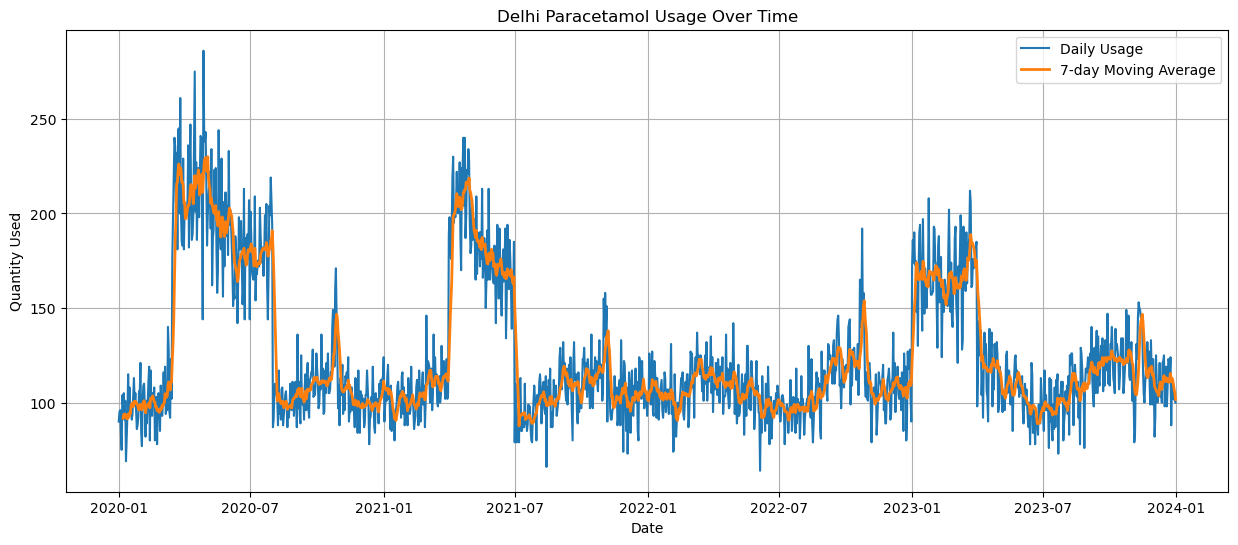


Delhi Paracetamol Statistics:
count    1461.000000
mean      124.405202
std        37.237263
min        64.000000
25%       100.000000
50%       112.000000
75%       136.000000
max       286.000000
Name: y, dtype: float64


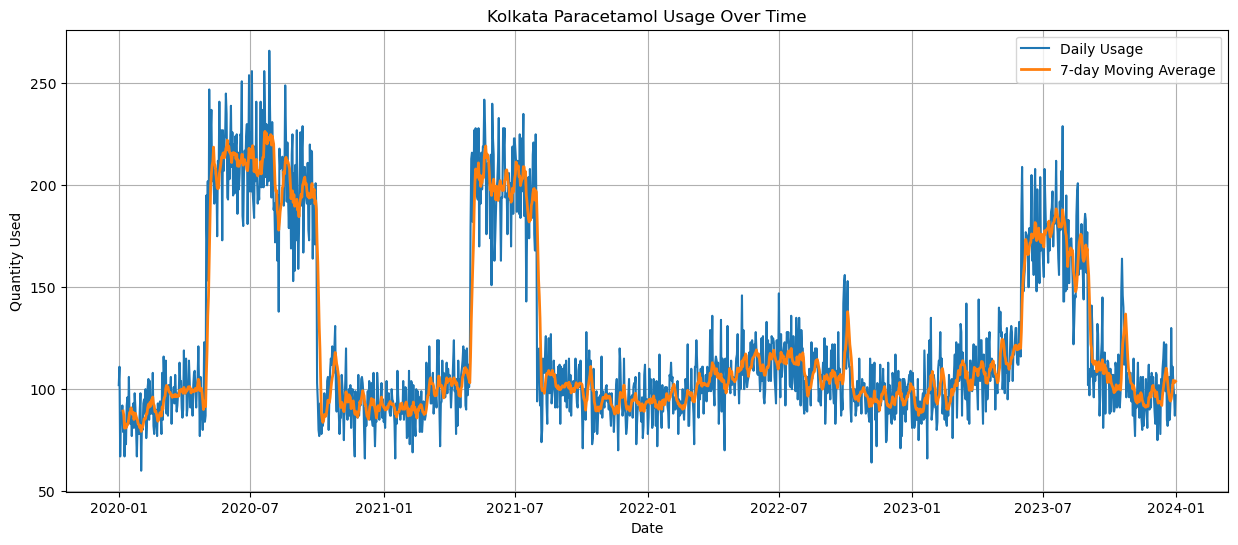


Kolkata Paracetamol Statistics:
count    1461.000000
mean      122.446954
std        43.789824
min        60.000000
25%        93.000000
50%       105.000000
75%       131.000000
max       266.000000
Name: y, dtype: float64


In [35]:
# Cell 2: Load and analyze data
def load_data(city, medicine):
    """Load Prophet-ready dataset for a specific city and medicine"""
    file_path = Path(f"../../dataset/data/{city}/processed/{medicine}_prophet.csv")
    df = pd.read_csv(file_path)
    df['ds'] = pd.to_datetime(df['ds'])
    return df

# Load data
delhi_paracetamol = load_data('delhi', 'paracetamol')
kolkata_paracetamol = load_data('kolkata', 'paracetamol')

# Basic analysis
def plot_basic_analysis(df, title):
    plt.figure(figsize=(15, 6))
    plt.plot(df['ds'], df['y'], label='Daily Usage')
    plt.plot(df['ds'], df['y'].rolling(window=7).mean(), 
            label='7-day Moving Average', linewidth=2)
    plt.title(f'{title} Usage Over Time')
    plt.xlabel('Date')
    plt.ylabel('Quantity Used')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"\n{title} Statistics:")
    print(df['y'].describe())

plot_basic_analysis(delhi_paracetamol, "Delhi Paracetamol")
plot_basic_analysis(kolkata_paracetamol, "Kolkata Paracetamol")

In [ ]:
# Cell 3: Train Prophet Models
def train_prophet_model(df, seasonality_mode='multiplicative'):
    """Train a Prophet model with specified parameters"""
    model = Prophet(
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )

    model.add_country_holidays(country_name='IN')
    model.fit(df)
    return model

# Train models for both cities
delhi_model = train_prophet_model(delhi_paracetamol)
kolkata_model = train_prophet_model(kolkata_paracetamol)

02:52:49 - cmdstanpy - INFO - Chain [1] start processing
02:52:49 - cmdstanpy - INFO - Chain [1] done processing
02:52:49 - cmdstanpy - INFO - Chain [1] start processing
02:52:49 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Cell 4: Make Predictions
def make_predictions(model, periods=90):
    """Generate future predictions"""
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast

# Generate predictions
delhi_forecast = make_predictions(delhi_model)
kolkata_forecast = make_predictions(kolkata_model)

<Figure size 1500x1000 with 0 Axes>

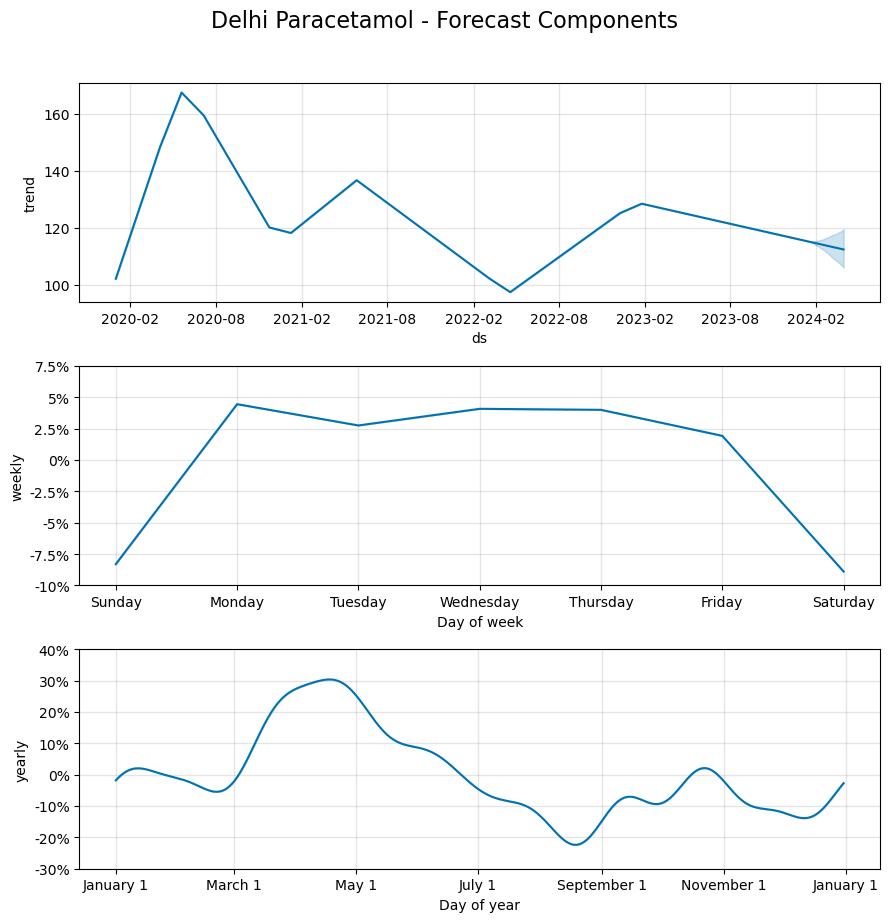

<Figure size 1500x600 with 0 Axes>

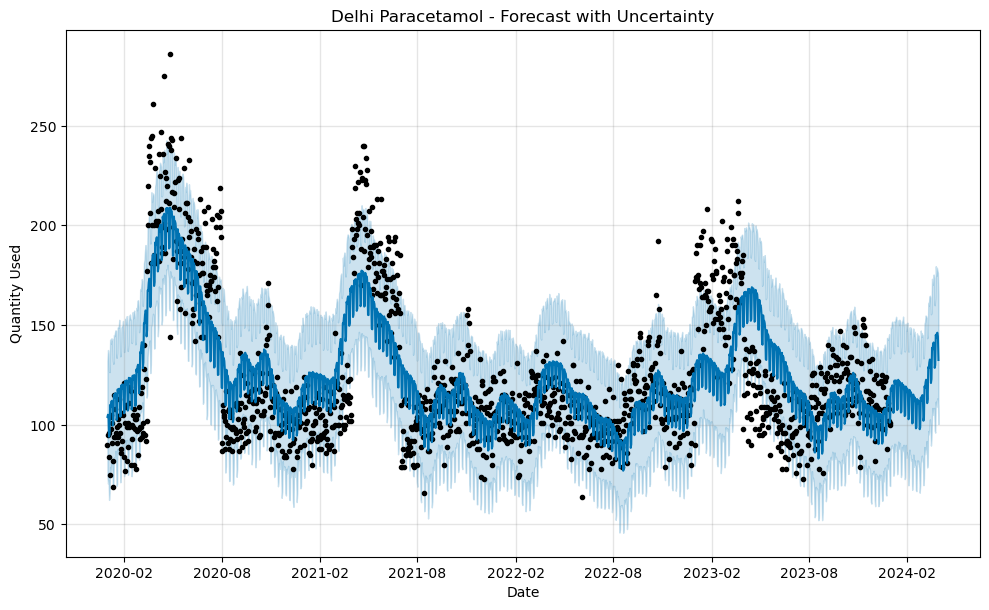

<Figure size 1500x1000 with 0 Axes>

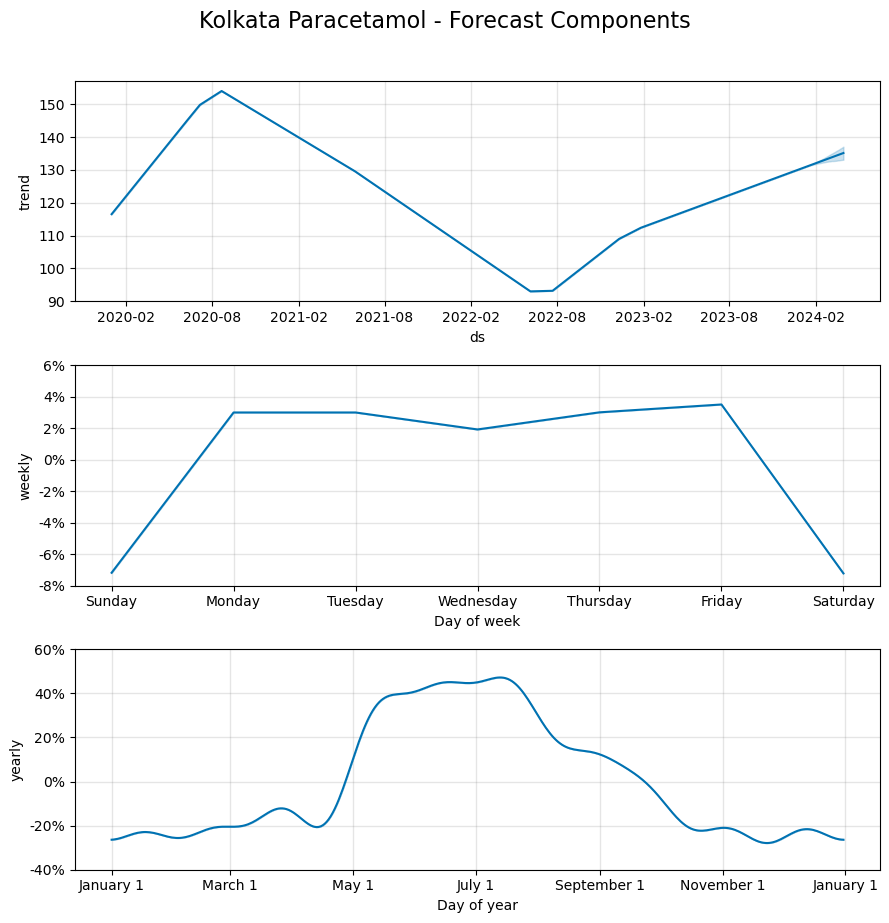

<Figure size 1500x600 with 0 Axes>

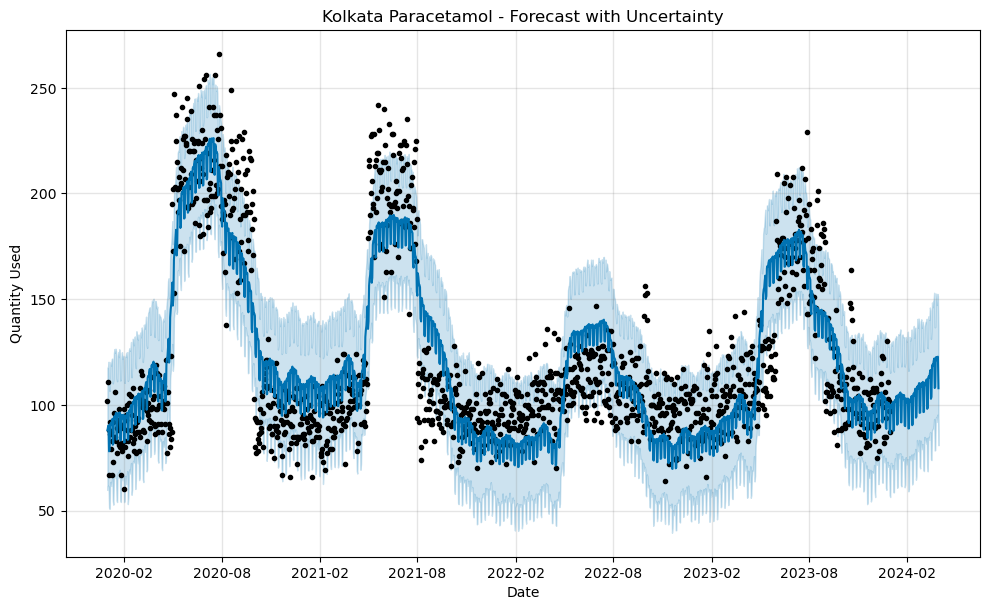

In [48]:
# Cell 5: Visualize Components and Forecasts
def plot_forecast(model, forecast, title):
    """Plot forecast components and predictions"""
    plt.figure(figsize=(15, 10))
    
    # Plot components
    model.plot_components(forecast)
    plt.suptitle(f'{title} - Forecast Components', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Plot forecast
    plt.figure(figsize=(15, 6))
    model.plot(forecast, uncertainty=True)
    plt.title(f'{title} - Forecast with Uncertainty')
    plt.xlabel('Date')
    plt.ylabel('Quantity Used')
    plt.grid(True)
    plt.show()

plot_forecast(delhi_model, delhi_forecast, "Delhi Paracetamol")
plot_forecast(kolkata_model, kolkata_forecast, "Kolkata Paracetamol")

Delhi Model Evaluation:
Model Evaluation Metrics:
Root Mean Square Error (RMSE): 24.57
Mean Absolute Error (MAE): 19.25
Mean Absolute Percentage Error (MAPE): 15.65%


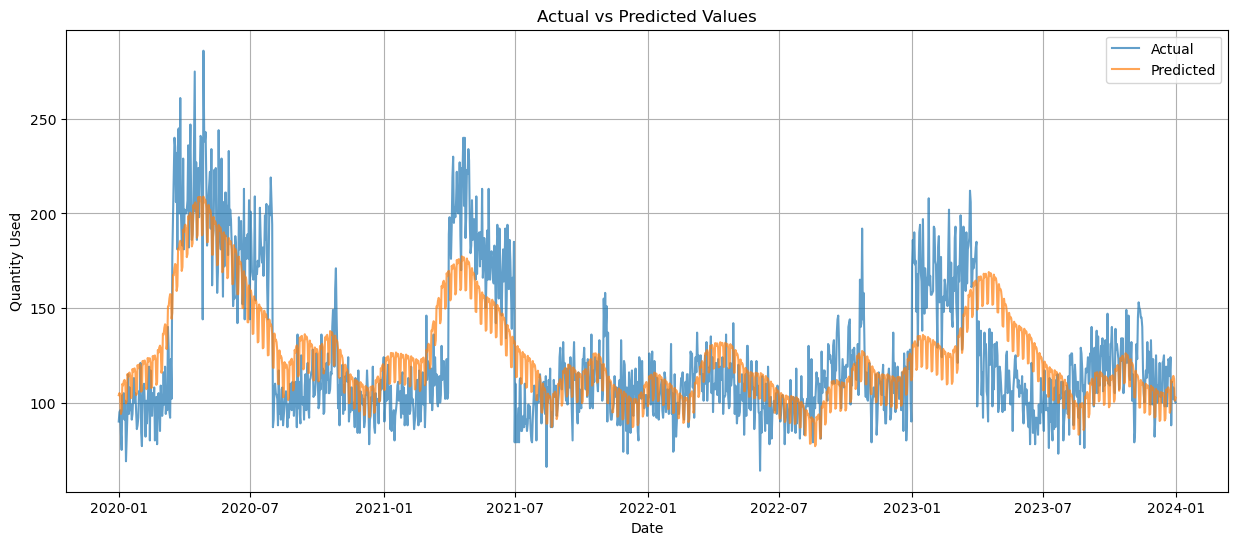

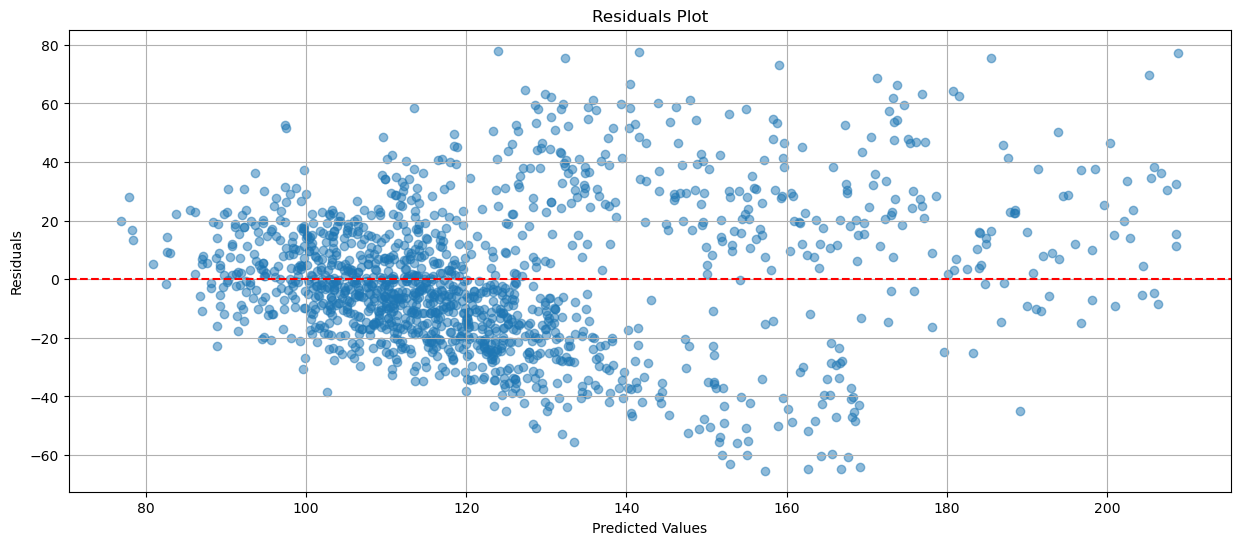


Kolkata Model Evaluation:
Model Evaluation Metrics:
Root Mean Square Error (RMSE): 22.56
Mean Absolute Error (MAE): 17.91
Mean Absolute Percentage Error (MAPE): 15.43%


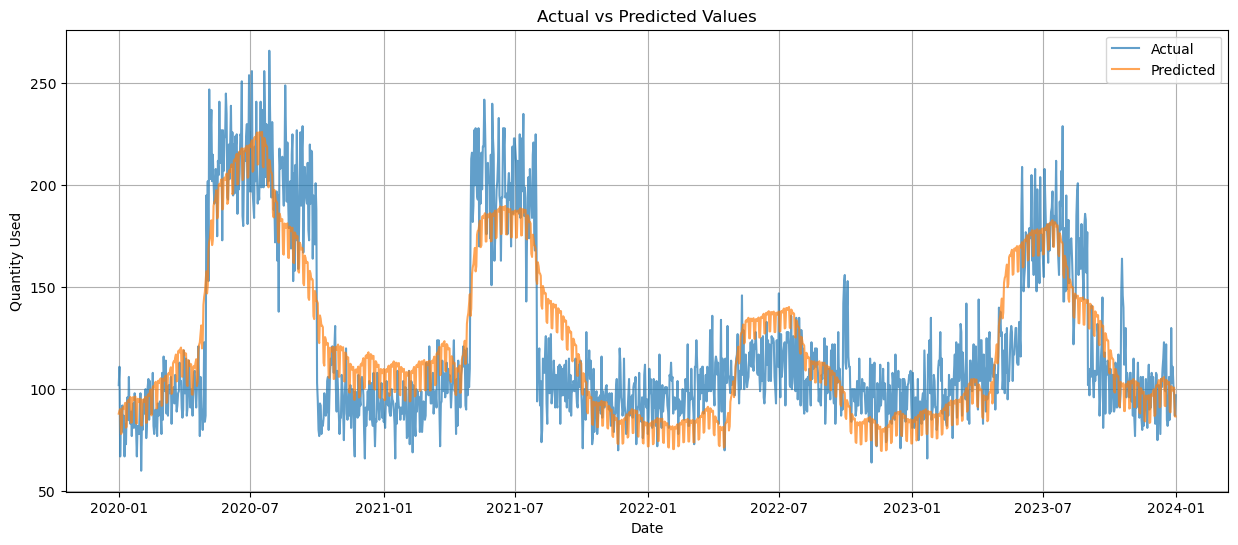

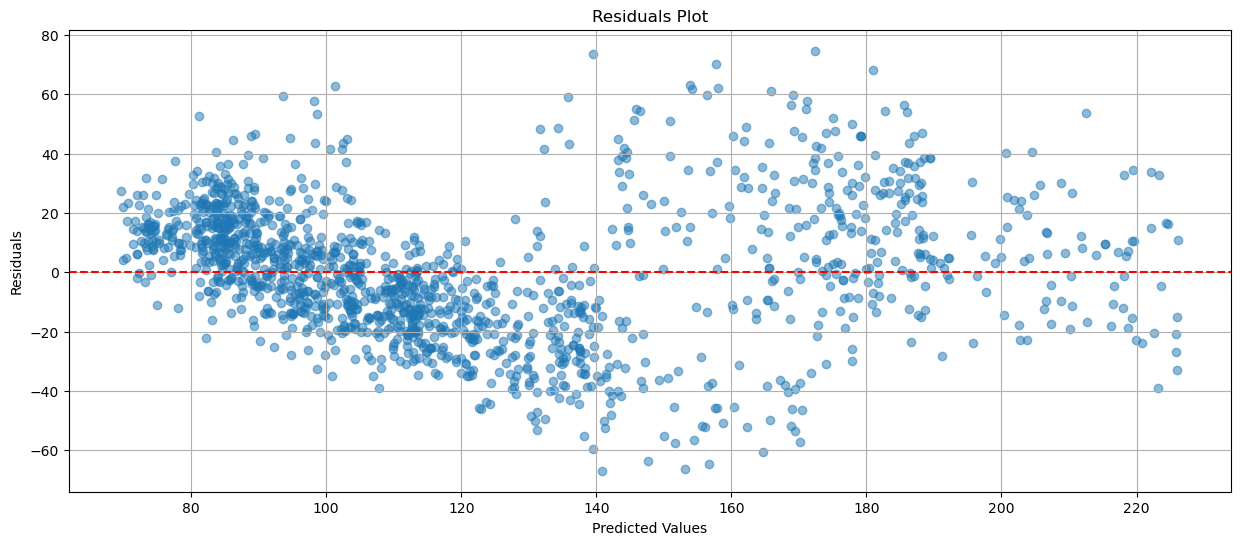

In [49]:
# Cell 6: Model Evaluation
def evaluate_model(df, model, forecast):
    """Evaluate model performance using various metrics"""
    # Calculate metrics on training data
    y_true = df['y'].values
    y_pred = forecast['yhat'][:len(y_true)]
    
    # Calculate error metrics
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print("Model Evaluation Metrics:")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(df['ds'], y_true, label='Actual', alpha=0.7)
    plt.plot(df['ds'], y_pred, label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('Quantity Used')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(15, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()
    
    return {'rmse': rmse, 'mae': mae, 'mape': mape}

# Evaluate both models
print("Delhi Model Evaluation:")
delhi_metrics = evaluate_model(delhi_paracetamol, delhi_model, delhi_forecast)

print("\nKolkata Model Evaluation:")
kolkata_metrics = evaluate_model(kolkata_paracetamol, kolkata_model, kolkata_forecast)

In [53]:
# Cell 8: Model Improvements and Tuning

# 1. Add Indian Holidays and Events
def train_enhanced_prophet_model(df, events_df=None, seasonality_mode='multiplicative'):
    """Train an enhanced Prophet model with holidays and events"""
    model = Prophet(
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    
    # Add Indian holidays
    model.add_country_holidays(country_name='IN')
    
    if events_df is not None:
        # Merge events with training data
        df = df.merge(events_df, on='ds', how='left')
        df['special_event'] = df['special_event'].fillna(0)
        
        # Add regressor
        model.add_regressor('special_event', mode='multiplicative')
        
    # Fit the model
    model.fit(df)
    return model

def make_predictions_with_events(model, periods=90, events_df=None):
    """Generate future predictions including special events"""
    future = model.make_future_dataframe(periods=periods)
    
    if events_df is not None:
        future = future.merge(events_df, on='ds', how='left')
        future['special_event'] = future['special_event'].fillna(0)
    
    forecast = model.predict(future)
    return forecast

# Create events dataframe with all dates
start_date = min(delhi_paracetamol['ds'].min(), kolkata_paracetamol['ds'].min())
end_date = max(delhi_paracetamol['ds'].max(), kolkata_paracetamol['ds'].max())
date_range = pd.date_range(start=start_date, end=end_date + pd.Timedelta(days=90))

events_df = pd.DataFrame({'ds': date_range})
events_df['special_event'] = 0

# Mark special event dates
special_dates = [
    '2020-10-25',  # Diwali 2020
    '2021-11-04',  # Diwali 2021
    '2022-10-24',  # Diwali 2022
    '2023-11-12'   # Diwali 2023
]

events_df.loc[events_df['ds'].isin(pd.to_datetime(special_dates)), 'special_event'] = 1

# Train enhanced models
delhi_enhanced_model = train_enhanced_prophet_model(delhi_paracetamol, events_df)
kolkata_enhanced_model = train_enhanced_prophet_model(kolkata_paracetamol, events_df)

# Make predictions with enhanced models
delhi_enhanced_forecast = make_predictions_with_events(delhi_enhanced_model, events_df=events_df)
kolkata_enhanced_forecast = make_predictions_with_events(kolkata_enhanced_model, events_df=events_df)

# 2. Hyperparameter Tuning
def tune_prophet_hyperparameters(df, events_df=None):
    """Perform grid search for Prophet hyperparameters"""
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['multiplicative', 'additive']
    }
    
    best_params = {}
    best_rmse = float('inf')
    
    for changepoint_prior in param_grid['changepoint_prior_scale']:
        for seasonality_prior in param_grid['seasonality_prior_scale']:
            for seasonality_mode in param_grid['seasonality_mode']:
                model = Prophet(
                    changepoint_prior_scale=changepoint_prior,
                    seasonality_prior_scale=seasonality_prior,
                    seasonality_mode=seasonality_mode
                )
                
                if events_df is not None:
                    df_with_events = df.merge(events_df, on='ds', how='left')
                    df_with_events['special_event'] = df_with_events['special_event'].fillna(0)
                    model.add_regressor('special_event', mode='multiplicative')
                    model.fit(df_with_events)
                else:
                    model.fit(df)
                
                df_cv = cross_validation(model, initial='180 days', 
                                       period='90 days', horizon='30 days')
                df_p = performance_metrics(df_cv)
                rmse = df_p['rmse'].mean()
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'changepoint_prior_scale': changepoint_prior,
                        'seasonality_prior_scale': seasonality_prior,
                        'seasonality_mode': seasonality_mode
                    }
                
                print(f"Parameters: {changepoint_prior}, {seasonality_prior}, {seasonality_mode}")
                print(f"RMSE: {rmse:.2f}")
                print("---")
    
    return best_params, best_rmse

# Tune models for both cities
print("Tuning Delhi Model:")
delhi_best_params, delhi_best_rmse = tune_prophet_hyperparameters(delhi_paracetamol, events_df)
print("\nBest Parameters for Delhi:")
print(delhi_best_params)
print(f"Best RMSE: {delhi_best_rmse:.2f}")

print("\nTuning Kolkata Model:")
kolkata_best_params, kolkata_best_rmse = tune_prophet_hyperparameters(kolkata_paracetamol, events_df)
print("\nBest Parameters for Kolkata:")
print(kolkata_best_params)
print(f"Best RMSE: {kolkata_best_rmse:.2f}")

# 3. Train Final Models with Best Parameters
delhi_final_model = Prophet(
    changepoint_prior_scale=delhi_best_params['changepoint_prior_scale'],
    seasonality_prior_scale=delhi_best_params['seasonality_prior_scale'],
    seasonality_mode=delhi_best_params['seasonality_mode']
)

# Add special event regressor to final models
delhi_final_model.add_regressor('special_event', mode='multiplicative')
delhi_paracetamol_with_events = delhi_paracetamol.merge(events_df, on='ds', how='left')
delhi_paracetamol_with_events['special_event'] = delhi_paracetamol_with_events['special_event'].fillna(0)
delhi_final_model.fit(delhi_paracetamol_with_events)

kolkata_final_model = Prophet(
    changepoint_prior_scale=kolkata_best_params['changepoint_prior_scale'],
    seasonality_prior_scale=kolkata_best_params['seasonality_prior_scale'],
    seasonality_mode=kolkata_best_params['seasonality_mode']
)

kolkata_final_model.add_regressor('special_event', mode='multiplicative')
kolkata_paracetamol_with_events = kolkata_paracetamol.merge(events_df, on='ds', how='left')
kolkata_paracetamol_with_events['special_event'] = kolkata_paracetamol_with_events['special_event'].fillna(0)
kolkata_final_model.fit(kolkata_paracetamol_with_events)

# 4. Compare Models
def compare_models(original_model, enhanced_model, final_model, df, city, events_df=None):
    """Compare performance of different model versions"""
    models = {
        'Original': original_model,
        'Enhanced': enhanced_model,
        'Tuned': final_model
    }
    
    results = {}
    
    print(f"\nProcessing {city} Models:")
    for name, model in models.items():
        print(f"\nEvaluating {name} model...")
        try:
            if name == 'Original':
                print("Running cross-validation for Original model...")
                df_cv = cross_validation(model, 
                                      initial='180 days',
                                      period='90 days',
                                      horizon='30 days',
                                      parallel=None)
            else:
                print(f"Running cross-validation for {name} model...")
                # For models with events
                df_cv = cross_validation(model,
                                      initial='180 days',
                                      period='90 days',
                                      horizon='30 days',
                                      parallel=None)
            
            print("Calculating performance metrics...")
            df_p = performance_metrics(df_cv)
            
            results[name] = {
                'RMSE': df_p['rmse'].mean(),
                'MAE': df_p['mae'].mean(),
                'MAPE': df_p['mape'].mean()
            }
            print(f"{name} model metrics calculated successfully")
            
        except Exception as e:
            print(f"Error in {name} model evaluation: {str(e)}")
            print("Traceback:")
            import traceback
            traceback.print_exc()
            continue
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(results).round(2)
    print(f"\n{city} Model Comparison:")
    print(comparison_df)
    
    return comparison_df

# Make sure the models are properly fitted before comparison
print("\nVerifying Delhi models...")
print("Original model:", delhi_model)
print("Enhanced model:", delhi_enhanced_model)
print("Final model:", delhi_final_model)

print("\nVerifying Kolkata models...")
print("Original model:", kolkata_model)
print("Enhanced model:", kolkata_enhanced_model)
print("Final model:", kolkata_final_model)

# Compare models for both cities
print("\nStarting model comparisons...")
delhi_comparison = compare_models(
    delhi_model, delhi_enhanced_model, delhi_final_model, 
    delhi_paracetamol, "Delhi", events_df
)

kolkata_comparison = compare_models(
    kolkata_model, kolkata_enhanced_model, kolkata_final_model, 
    kolkata_paracetamol, "Kolkata", events_df
)

# Display final results
print("\nFinal Comparison Results:")
print("\nDelhi Results:")
print(delhi_comparison)
print("\nKolkata Results:")
print(kolkata_comparison)

04:40:20 - cmdstanpy - INFO - Chain [1] start processing
04:40:20 - cmdstanpy - INFO - Chain [1] done processing
04:40:20 - cmdstanpy - INFO - Chain [1] start processing
04:40:20 - cmdstanpy - INFO - Chain [1] done processing
04:40:20 - cmdstanpy - INFO - Chain [1] start processing
04:40:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Tuning Delhi Model:


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:21 - cmdstanpy - INFO - Chain [1] start processing
04:40:21 - cmdstanpy - INFO - Chain [1] done processing
04:40:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:21 - cmdstanpy - INFO - Chain [1] start processing
04:40:21 - cmdstanpy - INFO - Chain [1] done processing
04:40:21 - cmdstanpy - INFO - Chain [1] start processing
04:40:21 - cmdstanpy - INFO - Chain [1] done processing
04:40:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:21 - cmdstanpy - INFO - Chain [1] start processing
04:40:21 - cmdstanpy - INFO - Chain [1] done processing
04:40:21 - cmdstanpy - INFO - Chain [1] start processing
04:40:21 - cmdstanpy - INFO - Chain [1] done processing
04:40:22 - cmdstanpy - INFO - Chain [1] start processing
04:40:22 - cmdstanpy - INFO - Chain [1] done processing
04:40:22 -

Parameters: 0.001, 0.01, multiplicative
RMSE: 38.73
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:23 - cmdstanpy - INFO - Chain [1] start processing
04:40:23 - cmdstanpy - INFO - Chain [1] done processing
04:40:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:24 - cmdstanpy - INFO - Chain [1] start processing
04:40:24 - cmdstanpy - INFO - Chain [1] done processing
04:40:24 - cmdstanpy - INFO - Chain [1] start processing
04:40:24 - cmdstanpy - INFO - Chain [1] done processing
04:40:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:24 - cmdstanpy - INFO - Chain [1] start processing
04:40:24 - cmdstanpy - INFO - Chain [1] done processing
04:40:25 - cmdstanpy - INFO - Chain [1] start processing
04:40:25 - cmdstanpy - INFO - Chain [1] done processing
04:40:25 - cmdstanpy - INFO - Chain [1] start processing
04:40:25 - cmdstanpy - INFO - Chain [1] done processing
04:40:25 -

Parameters: 0.001, 0.01, additive
RMSE: 37.95
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:27 - cmdstanpy - INFO - Chain [1] start processing
04:40:27 - cmdstanpy - INFO - Chain [1] done processing
04:40:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:27 - cmdstanpy - INFO - Chain [1] start processing
04:40:31 - cmdstanpy - INFO - Chain [1] done processing
04:40:31 - cmdstanpy - INFO - Chain [1] start processing
04:40:31 - cmdstanpy - INFO - Chain [1] done processing
04:40:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:31 - cmdstanpy - INFO - Chain [1] start processing
04:40:31 - cmdstanpy - INFO - Chain [1] done processing
04:40:31 - cmdstanpy - INFO - Chain [1] start processing
04:40:32 - cmdstanpy - INFO - Chain [1] done processing
04:40:32 - cmdstanpy - INFO - Chain [1] start processing
04:40:32 - cmdstanpy - INFO - Chain [1] done processing
04:40:32 -

Parameters: 0.001, 0.1, multiplicative
RMSE: 39.98
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:33 - cmdstanpy - INFO - Chain [1] start processing
04:40:33 - cmdstanpy - INFO - Chain [1] done processing
04:40:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:34 - cmdstanpy - INFO - Chain [1] start processing
04:40:34 - cmdstanpy - INFO - Chain [1] done processing
04:40:34 - cmdstanpy - INFO - Chain [1] start processing
04:40:34 - cmdstanpy - INFO - Chain [1] done processing
04:40:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:34 - cmdstanpy - INFO - Chain [1] start processing
04:40:34 - cmdstanpy - INFO - Chain [1] done processing
04:40:34 - cmdstanpy - INFO - Chain [1] start processing
04:40:34 - cmdstanpy - INFO - Chain [1] done processing
04:40:34 - cmdstanpy - INFO - Chain [1] start processing
04:40:34 - cmdstanpy - INFO - Chain [1] done processing
04:40:35 -

Parameters: 0.001, 0.1, additive
RMSE: 46.59
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:36 - cmdstanpy - INFO - Chain [1] start processing
04:40:36 - cmdstanpy - INFO - Chain [1] done processing
04:40:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:36 - cmdstanpy - INFO - Chain [1] start processing
04:40:37 - cmdstanpy - INFO - Chain [1] done processing
04:40:37 - cmdstanpy - INFO - Chain [1] start processing
04:40:37 - cmdstanpy - INFO - Chain [1] done processing
04:40:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:37 - cmdstanpy - INFO - Chain [1] start processing
04:40:37 - cmdstanpy - INFO - Chain [1] done processing
04:40:37 - cmdstanpy - INFO - Chain [1] start processing
04:40:37 - cmdstanpy - INFO - Chain [1] done processing
04:40:37 - cmdstanpy - INFO - Chain [1] start processing
04:40:37 - cmdstanpy - INFO - Chain [1] done processing
04:40:37 -

Parameters: 0.001, 1.0, multiplicative
RMSE: 83.02
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:39 - cmdstanpy - INFO - Chain [1] start processing
04:40:39 - cmdstanpy - INFO - Chain [1] done processing
04:40:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:39 - cmdstanpy - INFO - Chain [1] start processing
04:40:39 - cmdstanpy - INFO - Chain [1] done processing
04:40:40 - cmdstanpy - INFO - Chain [1] start processing
04:40:40 - cmdstanpy - INFO - Chain [1] done processing
04:40:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:40 - cmdstanpy - INFO - Chain [1] start processing
04:40:40 - cmdstanpy - INFO - Chain [1] done processing
04:40:40 - cmdstanpy - INFO - Chain [1] start processing
04:40:40 - cmdstanpy - INFO - Chain [1] done processing
04:40:40 - cmdstanpy - INFO - Chain [1] start processing
04:40:40 - cmdstanpy - INFO - Chain [1] done processing
04:40:40 -

Parameters: 0.001, 1.0, additive
RMSE: 85.23
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:42 - cmdstanpy - INFO - Chain [1] start processing
04:40:42 - cmdstanpy - INFO - Chain [1] done processing
04:40:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:42 - cmdstanpy - INFO - Chain [1] start processing
04:40:42 - cmdstanpy - INFO - Chain [1] done processing
04:40:42 - cmdstanpy - INFO - Chain [1] start processing
04:40:42 - cmdstanpy - INFO - Chain [1] done processing
04:40:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:42 - cmdstanpy - INFO - Chain [1] start processing
04:40:43 - cmdstanpy - INFO - Chain [1] done processing
04:40:43 - cmdstanpy - INFO - Chain [1] start processing
04:40:43 - cmdstanpy - INFO - Chain [1] done processing
04:40:43 - cmdstanpy - INFO - Chain [1] start processing
04:40:43 - cmdstanpy - INFO - Chain [1] done processing
04:40:43 -

Parameters: 0.001, 10.0, multiplicative
RMSE: 238.62
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:45 - cmdstanpy - INFO - Chain [1] start processing
04:40:45 - cmdstanpy - INFO - Chain [1] done processing
04:40:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:45 - cmdstanpy - INFO - Chain [1] start processing
04:40:45 - cmdstanpy - INFO - Chain [1] done processing
04:40:45 - cmdstanpy - INFO - Chain [1] start processing
04:40:45 - cmdstanpy - INFO - Chain [1] done processing
04:40:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:40:45 - cmdstanpy - INFO - Chain [1] start processing
04:40:50 - cmdstanpy - INFO - Chain [1] done processing
04:40:50 - cmdstanpy - INFO - Chain [1] start processing
04:40:50 - cmdstanpy - INFO - Chain [1] done processing
04:40:50 - cmdstanpy - INFO - Chain [1] start processing
04:40:50 - cmdstanpy - INFO - Chain [1] done processing
04:40:50 -

Parameters: 0.001, 10.0, additive
RMSE: 372.34
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:52 - cmdstanpy - INFO - Chain [1] start processing
04:40:52 - cmdstanpy - INFO - Chain [1] done processing
04:40:52 - cmdstanpy - INFO - Chain [1] start processing
04:40:52 - cmdstanpy - INFO - Chain [1] done processing
04:40:52 - cmdstanpy - INFO - Chain [1] start processing
04:40:52 - cmdstanpy - INFO - Chain [1] done processing
04:40:52 - cmdstanpy - INFO - Chain [1] start processing
04:40:52 - cmdstanpy - INFO - Chain [1] done processing
04:40:53 - cmdstanpy - INFO - Chain [1] start processing
04:40:53 - cmdstanpy - INFO - Chain [1] done processing
04:40:53 - cmdstanpy - INFO - Chain [1] start processing
04:40:53 - cmdstanpy - INFO - Chain [1] done processing
04:40:53 - cmdstanpy - INFO - Chain [1] start processing
04:40:53 - cmdstanpy - INFO - Chain [1] done processing
04:40:53 - cmdstanpy - INFO - Chain [1] start processing
04:40:53 - cmdstanpy - INFO - Chain [1] done processing
04:40:53 - cmdstanpy - INFO - Chain [1] start processing
04:40:53 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 0.01, multiplicative
RMSE: 32.62
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:54 - cmdstanpy - INFO - Chain [1] start processing
04:40:54 - cmdstanpy - INFO - Chain [1] done processing
04:40:55 - cmdstanpy - INFO - Chain [1] start processing
04:40:55 - cmdstanpy - INFO - Chain [1] done processing
04:40:55 - cmdstanpy - INFO - Chain [1] start processing
04:40:55 - cmdstanpy - INFO - Chain [1] done processing
04:40:55 - cmdstanpy - INFO - Chain [1] start processing
04:40:55 - cmdstanpy - INFO - Chain [1] done processing
04:40:55 - cmdstanpy - INFO - Chain [1] start processing
04:40:55 - cmdstanpy - INFO - Chain [1] done processing
04:40:55 - cmdstanpy - INFO - Chain [1] start processing
04:40:55 - cmdstanpy - INFO - Chain [1] done processing
04:40:55 - cmdstanpy - INFO - Chain [1] start processing
04:40:55 - cmdstanpy - INFO - Chain [1] done processing
04:40:55 - cmdstanpy - INFO - Chain [1] start processing
04:40:56 - cmdstanpy - INFO - Chain [1] done processing
04:40:56 - cmdstanpy - INFO - Chain [1] start processing
04:40:56 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 0.01, additive
RMSE: 34.86
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:57 - cmdstanpy - INFO - Chain [1] start processing
04:40:57 - cmdstanpy - INFO - Chain [1] done processing
04:40:57 - cmdstanpy - INFO - Chain [1] start processing
04:40:57 - cmdstanpy - INFO - Chain [1] done processing
04:40:57 - cmdstanpy - INFO - Chain [1] start processing
04:40:57 - cmdstanpy - INFO - Chain [1] done processing
04:40:57 - cmdstanpy - INFO - Chain [1] start processing
04:40:57 - cmdstanpy - INFO - Chain [1] done processing
04:40:58 - cmdstanpy - INFO - Chain [1] start processing
04:40:58 - cmdstanpy - INFO - Chain [1] done processing
04:40:58 - cmdstanpy - INFO - Chain [1] start processing
04:40:58 - cmdstanpy - INFO - Chain [1] done processing
04:40:58 - cmdstanpy - INFO - Chain [1] start processing
04:40:58 - cmdstanpy - INFO - Chain [1] done processing
04:40:58 - cmdstanpy - INFO - Chain [1] start processing
04:40:58 - cmdstanpy - INFO - Chain [1] done processing
04:40:58 - cmdstanpy - INFO - Chain [1] start processing
04:40:58 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 0.1, multiplicative
RMSE: 40.96
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:40:59 - cmdstanpy - INFO - Chain [1] start processing
04:40:59 - cmdstanpy - INFO - Chain [1] done processing
04:41:00 - cmdstanpy - INFO - Chain [1] start processing
04:41:00 - cmdstanpy - INFO - Chain [1] done processing
04:41:00 - cmdstanpy - INFO - Chain [1] start processing
04:41:00 - cmdstanpy - INFO - Chain [1] done processing
04:41:00 - cmdstanpy - INFO - Chain [1] start processing
04:41:00 - cmdstanpy - INFO - Chain [1] done processing
04:41:00 - cmdstanpy - INFO - Chain [1] start processing
04:41:00 - cmdstanpy - INFO - Chain [1] done processing
04:41:00 - cmdstanpy - INFO - Chain [1] start processing
04:41:00 - cmdstanpy - INFO - Chain [1] done processing
04:41:00 - cmdstanpy - INFO - Chain [1] start processing
04:41:00 - cmdstanpy - INFO - Chain [1] done processing
04:41:00 - cmdstanpy - INFO - Chain [1] start processing
04:41:00 - cmdstanpy - INFO - Chain [1] done processing
04:41:01 - cmdstanpy - INFO - Chain [1] start processing
04:41:01 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 0.1, additive
RMSE: 39.50
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:02 - cmdstanpy - INFO - Chain [1] start processing
04:41:02 - cmdstanpy - INFO - Chain [1] done processing
04:41:02 - cmdstanpy - INFO - Chain [1] start processing
04:41:02 - cmdstanpy - INFO - Chain [1] done processing
04:41:02 - cmdstanpy - INFO - Chain [1] start processing
04:41:02 - cmdstanpy - INFO - Chain [1] done processing
04:41:02 - cmdstanpy - INFO - Chain [1] start processing
04:41:02 - cmdstanpy - INFO - Chain [1] done processing
04:41:02 - cmdstanpy - INFO - Chain [1] start processing
04:41:02 - cmdstanpy - INFO - Chain [1] done processing
04:41:03 - cmdstanpy - INFO - Chain [1] start processing
04:41:03 - cmdstanpy - INFO - Chain [1] done processing
04:41:03 - cmdstanpy - INFO - Chain [1] start processing
04:41:03 - cmdstanpy - INFO - Chain [1] done processing
04:41:03 - cmdstanpy - INFO - Chain [1] start processing
04:41:03 - cmdstanpy - INFO - Chain [1] done processing
04:41:03 - cmdstanpy - INFO - Chain [1] start processing
04:41:03 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 1.0, multiplicative
RMSE: 41.03
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:04 - cmdstanpy - INFO - Chain [1] start processing
04:41:04 - cmdstanpy - INFO - Chain [1] done processing
04:41:04 - cmdstanpy - INFO - Chain [1] start processing
04:41:04 - cmdstanpy - INFO - Chain [1] done processing
04:41:05 - cmdstanpy - INFO - Chain [1] start processing
04:41:05 - cmdstanpy - INFO - Chain [1] done processing
04:41:05 - cmdstanpy - INFO - Chain [1] start processing
04:41:05 - cmdstanpy - INFO - Chain [1] done processing
04:41:05 - cmdstanpy - INFO - Chain [1] start processing
04:41:05 - cmdstanpy - INFO - Chain [1] done processing
04:41:05 - cmdstanpy - INFO - Chain [1] start processing
04:41:05 - cmdstanpy - INFO - Chain [1] done processing
04:41:05 - cmdstanpy - INFO - Chain [1] start processing
04:41:05 - cmdstanpy - INFO - Chain [1] done processing
04:41:05 - cmdstanpy - INFO - Chain [1] start processing
04:41:05 - cmdstanpy - INFO - Chain [1] done processing
04:41:05 - cmdstanpy - INFO - Chain [1] start processing
04:41:05 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 1.0, additive
RMSE: 39.17
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:07 - cmdstanpy - INFO - Chain [1] start processing
04:41:07 - cmdstanpy - INFO - Chain [1] done processing
04:41:07 - cmdstanpy - INFO - Chain [1] start processing
04:41:07 - cmdstanpy - INFO - Chain [1] done processing
04:41:07 - cmdstanpy - INFO - Chain [1] start processing
04:41:07 - cmdstanpy - INFO - Chain [1] done processing
04:41:07 - cmdstanpy - INFO - Chain [1] start processing
04:41:07 - cmdstanpy - INFO - Chain [1] done processing
04:41:07 - cmdstanpy - INFO - Chain [1] start processing
04:41:07 - cmdstanpy - INFO - Chain [1] done processing
04:41:07 - cmdstanpy - INFO - Chain [1] start processing
04:41:07 - cmdstanpy - INFO - Chain [1] done processing
04:41:08 - cmdstanpy - INFO - Chain [1] start processing
04:41:08 - cmdstanpy - INFO - Chain [1] done processing
04:41:08 - cmdstanpy - INFO - Chain [1] start processing
04:41:08 - cmdstanpy - INFO - Chain [1] done processing
04:41:08 - cmdstanpy - INFO - Chain [1] start processing
04:41:08 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 10.0, multiplicative
RMSE: 40.82
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:09 - cmdstanpy - INFO - Chain [1] start processing
04:41:09 - cmdstanpy - INFO - Chain [1] done processing
04:41:09 - cmdstanpy - INFO - Chain [1] start processing
04:41:09 - cmdstanpy - INFO - Chain [1] done processing
04:41:09 - cmdstanpy - INFO - Chain [1] start processing
04:41:09 - cmdstanpy - INFO - Chain [1] done processing
04:41:10 - cmdstanpy - INFO - Chain [1] start processing
04:41:10 - cmdstanpy - INFO - Chain [1] done processing
04:41:10 - cmdstanpy - INFO - Chain [1] start processing
04:41:10 - cmdstanpy - INFO - Chain [1] done processing
04:41:10 - cmdstanpy - INFO - Chain [1] start processing
04:41:10 - cmdstanpy - INFO - Chain [1] done processing
04:41:10 - cmdstanpy - INFO - Chain [1] start processing
04:41:10 - cmdstanpy - INFO - Chain [1] done processing
04:41:10 - cmdstanpy - INFO - Chain [1] start processing
04:41:10 - cmdstanpy - INFO - Chain [1] done processing
04:41:10 - cmdstanpy - INFO - Chain [1] start processing
04:41:10 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 10.0, additive
RMSE: 38.98
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:12 - cmdstanpy - INFO - Chain [1] start processing
04:41:12 - cmdstanpy - INFO - Chain [1] done processing
04:41:12 - cmdstanpy - INFO - Chain [1] start processing
04:41:12 - cmdstanpy - INFO - Chain [1] done processing
04:41:12 - cmdstanpy - INFO - Chain [1] start processing
04:41:12 - cmdstanpy - INFO - Chain [1] done processing
04:41:12 - cmdstanpy - INFO - Chain [1] start processing
04:41:12 - cmdstanpy - INFO - Chain [1] done processing
04:41:12 - cmdstanpy - INFO - Chain [1] start processing
04:41:12 - cmdstanpy - INFO - Chain [1] done processing
04:41:12 - cmdstanpy - INFO - Chain [1] start processing
04:41:12 - cmdstanpy - INFO - Chain [1] done processing
04:41:12 - cmdstanpy - INFO - Chain [1] start processing
04:41:13 - cmdstanpy - INFO - Chain [1] done processing
04:41:13 - cmdstanpy - INFO - Chain [1] start processing
04:41:13 - cmdstanpy - INFO - Chain [1] done processing
04:41:13 - cmdstanpy - INFO - Chain [1] start processing
04:41:13 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 0.01, multiplicative
RMSE: 35.17
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:14 - cmdstanpy - INFO - Chain [1] start processing
04:41:14 - cmdstanpy - INFO - Chain [1] done processing
04:41:14 - cmdstanpy - INFO - Chain [1] start processing
04:41:14 - cmdstanpy - INFO - Chain [1] done processing
04:41:15 - cmdstanpy - INFO - Chain [1] start processing
04:41:15 - cmdstanpy - INFO - Chain [1] done processing
04:41:15 - cmdstanpy - INFO - Chain [1] start processing
04:41:15 - cmdstanpy - INFO - Chain [1] done processing
04:41:15 - cmdstanpy - INFO - Chain [1] start processing
04:41:15 - cmdstanpy - INFO - Chain [1] done processing
04:41:15 - cmdstanpy - INFO - Chain [1] start processing
04:41:15 - cmdstanpy - INFO - Chain [1] done processing
04:41:15 - cmdstanpy - INFO - Chain [1] start processing
04:41:15 - cmdstanpy - INFO - Chain [1] done processing
04:41:15 - cmdstanpy - INFO - Chain [1] start processing
04:41:15 - cmdstanpy - INFO - Chain [1] done processing
04:41:15 - cmdstanpy - INFO - Chain [1] start processing
04:41:16 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 0.01, additive
RMSE: 36.53
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:17 - cmdstanpy - INFO - Chain [1] start processing
04:41:17 - cmdstanpy - INFO - Chain [1] done processing
04:41:17 - cmdstanpy - INFO - Chain [1] start processing
04:41:17 - cmdstanpy - INFO - Chain [1] done processing
04:41:17 - cmdstanpy - INFO - Chain [1] start processing
04:41:17 - cmdstanpy - INFO - Chain [1] done processing
04:41:17 - cmdstanpy - INFO - Chain [1] start processing
04:41:17 - cmdstanpy - INFO - Chain [1] done processing
04:41:18 - cmdstanpy - INFO - Chain [1] start processing
04:41:18 - cmdstanpy - INFO - Chain [1] done processing
04:41:18 - cmdstanpy - INFO - Chain [1] start processing
04:41:18 - cmdstanpy - INFO - Chain [1] done processing
04:41:18 - cmdstanpy - INFO - Chain [1] start processing
04:41:18 - cmdstanpy - INFO - Chain [1] done processing
04:41:18 - cmdstanpy - INFO - Chain [1] start processing
04:41:18 - cmdstanpy - INFO - Chain [1] done processing
04:41:18 - cmdstanpy - INFO - Chain [1] start processing
04:41:18 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 0.1, multiplicative
RMSE: 46.73
---


04:41:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:20 - cmdstanpy - INFO - Chain [1] start processing
04:41:20 - cmdstanpy - INFO - Chain [1] done processing
04:41:20 - cmdstanpy - INFO - Chain [1] start processing
04:41:20 - cmdstanpy - INFO - Chain [1] done processing
04:41:20 - cmdstanpy - INFO - Chain [1] start processing
04:41:20 - cmdstanpy - INFO - Chain [1] done processing
04:41:20 - cmdstanpy - INFO - Chain [1] start processing
04:41:20 - cmdstanpy - INFO - Chain [1] done processing
04:41:20 - cmdstanpy - INFO - Chain [1] start processing
04:41:20 - cmdstanpy - INFO - Chain [1] done processing
04:41:21 - cmdstanpy - INFO - Chain [1] start processing
04:41:21 - cmdstanpy - INFO - Chain [1] done processing
04:41:21 - cmdstanpy - INFO - Chain [1] start processing
04:41:21 - cmdstanpy - INFO - Chain [1] done processing
04:41:21 - cmdstanpy - INFO - Chain [1] start processing
04:41:21 - cmdstanpy - INFO - Chain [1] done processing
04:41:21 - cmdstanpy - INFO - Chain [1] start processing
04:41:21 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 0.1, additive
RMSE: 43.43
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:23 - cmdstanpy - INFO - Chain [1] start processing
04:41:23 - cmdstanpy - INFO - Chain [1] done processing
04:41:23 - cmdstanpy - INFO - Chain [1] start processing
04:41:23 - cmdstanpy - INFO - Chain [1] done processing
04:41:23 - cmdstanpy - INFO - Chain [1] start processing
04:41:23 - cmdstanpy - INFO - Chain [1] done processing
04:41:23 - cmdstanpy - INFO - Chain [1] start processing
04:41:23 - cmdstanpy - INFO - Chain [1] done processing
04:41:23 - cmdstanpy - INFO - Chain [1] start processing
04:41:23 - cmdstanpy - INFO - Chain [1] done processing
04:41:23 - cmdstanpy - INFO - Chain [1] start processing
04:41:23 - cmdstanpy - INFO - Chain [1] done processing
04:41:24 - cmdstanpy - INFO - Chain [1] start processing
04:41:24 - cmdstanpy - INFO - Chain [1] done processing
04:41:24 - cmdstanpy - INFO - Chain [1] start processing
04:41:24 - cmdstanpy - INFO - Chain [1] done processing
04:41:24 - cmdstanpy - INFO - Chain [1] start processing
04:41:24 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 1.0, multiplicative
RMSE: 47.65
---


04:41:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:25 - cmdstanpy - INFO - Chain [1] start processing
04:41:25 - cmdstanpy - INFO - Chain [1] done processing
04:41:25 - cmdstanpy - INFO - Chain [1] start processing
04:41:25 - cmdstanpy - INFO - Chain [1] done processing
04:41:26 - cmdstanpy - INFO - Chain [1] start processing
04:41:26 - cmdstanpy - INFO - Chain [1] done processing
04:41:26 - cmdstanpy - INFO - Chain [1] start processing
04:41:26 - cmdstanpy - INFO - Chain [1] done processing
04:41:26 - cmdstanpy - INFO - Chain [1] start processing
04:41:26 - cmdstanpy - INFO - Chain [1] done processing
04:41:26 - cmdstanpy - INFO - Chain [1] start processing
04:41:26 - cmdstanpy - INFO - Chain [1] done processing
04:41:26 - cmdstanpy - INFO - Chain [1] start processing
04:41:26 - cmdstanpy - INFO - Chain [1] done processing
04:41:26 - cmdstanpy - INFO - Chain [1] start processing
04:41:26 - cmdstanpy - INFO - Chain [1] done processing
04:41:27 - cmdstanpy - INFO - Chain [1] start processing
04:41:27 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 1.0, additive
RMSE: 43.61
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:28 - cmdstanpy - INFO - Chain [1] start processing
04:41:28 - cmdstanpy - INFO - Chain [1] done processing
04:41:28 - cmdstanpy - INFO - Chain [1] start processing
04:41:28 - cmdstanpy - INFO - Chain [1] done processing
04:41:28 - cmdstanpy - INFO - Chain [1] start processing
04:41:28 - cmdstanpy - INFO - Chain [1] done processing
04:41:28 - cmdstanpy - INFO - Chain [1] start processing
04:41:29 - cmdstanpy - INFO - Chain [1] done processing
04:41:29 - cmdstanpy - INFO - Chain [1] start processing
04:41:29 - cmdstanpy - INFO - Chain [1] done processing
04:41:29 - cmdstanpy - INFO - Chain [1] start processing
04:41:29 - cmdstanpy - INFO - Chain [1] done processing
04:41:29 - cmdstanpy - INFO - Chain [1] start processing
04:41:29 - cmdstanpy - INFO - Chain [1] done processing
04:41:29 - cmdstanpy - INFO - Chain [1] start processing
04:41:29 - cmdstanpy - INFO - Chain [1] done processing
04:41:29 - cmdstanpy - INFO - Chain [1] start processing
04:41:29 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 10.0, multiplicative
RMSE: 47.52
---


04:41:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:31 - cmdstanpy - INFO - Chain [1] start processing
04:41:31 - cmdstanpy - INFO - Chain [1] done processing
04:41:31 - cmdstanpy - INFO - Chain [1] start processing
04:41:31 - cmdstanpy - INFO - Chain [1] done processing
04:41:31 - cmdstanpy - INFO - Chain [1] start processing
04:41:31 - cmdstanpy - INFO - Chain [1] done processing
04:41:31 - cmdstanpy - INFO - Chain [1] start processing
04:41:31 - cmdstanpy - INFO - Chain [1] done processing
04:41:31 - cmdstanpy - INFO - Chain [1] start processing
04:41:31 - cmdstanpy - INFO - Chain [1] done processing
04:41:32 - cmdstanpy - INFO - Chain [1] start processing
04:41:32 - cmdstanpy - INFO - Chain [1] done processing
04:41:32 - cmdstanpy - INFO - Chain [1] start processing
04:41:32 - cmdstanpy - INFO - Chain [1] done processing
04:41:32 - cmdstanpy - INFO - Chain [1] start processing
04:41:32 - cmdstanpy - INFO - Chain [1] done processing
04:41:32 - cmdstanpy - INFO - Chain [1] start processing
04:41:32 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 10.0, additive
RMSE: 43.58
---


04:41:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:34 - cmdstanpy - INFO - Chain [1] start processing
04:41:34 - cmdstanpy - INFO - Chain [1] done processing
04:41:34 - cmdstanpy - INFO - Chain [1] start processing
04:41:34 - cmdstanpy - INFO - Chain [1] done processing
04:41:34 - cmdstanpy - INFO - Chain [1] start processing
04:41:34 - cmdstanpy - INFO - Chain [1] done processing
04:41:34 - cmdstanpy - INFO - Chain [1] start processing
04:41:34 - cmdstanpy - INFO - Chain [1] done processing
04:41:34 - cmdstanpy - INFO - Chain [1] start processing
04:41:34 - cmdstanpy - INFO - Chain [1] done processing
04:41:34 - cmdstanpy - INFO - Chain [1] start processing
04:41:35 - cmdstanpy - INFO - Chain [1] done processing
04:41:35 - cmdstanpy - INFO - Chain [1] start processing
04:41:35 - cmdstanpy - INFO - Chain [1] done processing
04:41:35 - cmdstanpy - INFO - Chain [1] start processing
04:41:35 - cmdstanpy - INFO - Chain [1] done processing
04:41:35 - cmdstanpy - INFO - Chain [1] start processing
04:41:35 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 0.01, multiplicative
RMSE: 36.48
---


04:41:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:37 - cmdstanpy - INFO - Chain [1] start processing
04:41:37 - cmdstanpy - INFO - Chain [1] done processing
04:41:37 - cmdstanpy - INFO - Chain [1] start processing
04:41:37 - cmdstanpy - INFO - Chain [1] done processing
04:41:37 - cmdstanpy - INFO - Chain [1] start processing
04:41:37 - cmdstanpy - INFO - Chain [1] done processing
04:41:37 - cmdstanpy - INFO - Chain [1] start processing
04:41:37 - cmdstanpy - INFO - Chain [1] done processing
04:41:37 - cmdstanpy - INFO - Chain [1] start processing
04:41:37 - cmdstanpy - INFO - Chain [1] done processing
04:41:38 - cmdstanpy - INFO - Chain [1] start processing
04:41:38 - cmdstanpy - INFO - Chain [1] done processing
04:41:38 - cmdstanpy - INFO - Chain [1] start processing
04:41:38 - cmdstanpy - INFO - Chain [1] done processing
04:41:38 - cmdstanpy - INFO - Chain [1] start processing
04:41:38 - cmdstanpy - INFO - Chain [1] done processing
04:41:38 - cmdstanpy - INFO - Chain [1] start processing
04:41:38 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 0.01, additive
RMSE: 33.14
---


04:41:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:40 - cmdstanpy - INFO - Chain [1] start processing
04:41:40 - cmdstanpy - INFO - Chain [1] done processing
04:41:40 - cmdstanpy - INFO - Chain [1] start processing
04:41:40 - cmdstanpy - INFO - Chain [1] done processing
04:41:40 - cmdstanpy - INFO - Chain [1] start processing
04:41:40 - cmdstanpy - INFO - Chain [1] done processing
04:41:40 - cmdstanpy - INFO - Chain [1] start processing
04:41:40 - cmdstanpy - INFO - Chain [1] done processing
04:41:40 - cmdstanpy - INFO - Chain [1] start processing
04:41:41 - cmdstanpy - INFO - Chain [1] done processing
04:41:41 - cmdstanpy - INFO - Chain [1] start processing
04:41:41 - cmdstanpy - INFO - Chain [1] done processing
04:41:41 - cmdstanpy - INFO - Chain [1] start processing
04:41:41 - cmdstanpy - INFO - Chain [1] done processing
04:41:41 - cmdstanpy - INFO - Chain [1] start processing
04:41:41 - cmdstanpy - INFO - Chain [1] done processing
04:41:41 - cmdstanpy - INFO - Chain [1] start processing
04:41:41 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 0.1, multiplicative
RMSE: 45.25
---


04:41:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:43 - cmdstanpy - INFO - Chain [1] start processing
04:41:43 - cmdstanpy - INFO - Chain [1] done processing
04:41:43 - cmdstanpy - INFO - Chain [1] start processing
04:41:43 - cmdstanpy - INFO - Chain [1] done processing
04:41:43 - cmdstanpy - INFO - Chain [1] start processing
04:41:43 - cmdstanpy - INFO - Chain [1] done processing
04:41:43 - cmdstanpy - INFO - Chain [1] start processing
04:41:43 - cmdstanpy - INFO - Chain [1] done processing
04:41:44 - cmdstanpy - INFO - Chain [1] start processing
04:41:44 - cmdstanpy - INFO - Chain [1] done processing
04:41:44 - cmdstanpy - INFO - Chain [1] start processing
04:41:44 - cmdstanpy - INFO - Chain [1] done processing
04:41:44 - cmdstanpy - INFO - Chain [1] start processing
04:41:44 - cmdstanpy - INFO - Chain [1] done processing
04:41:44 - cmdstanpy - INFO - Chain [1] start processing
04:41:44 - cmdstanpy - INFO - Chain [1] done processing
04:41:44 - cmdstanpy - INFO - Chain [1] start processing
04:41:44 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 0.1, additive
RMSE: 43.77
---


04:41:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:46 - cmdstanpy - INFO - Chain [1] start processing
04:41:46 - cmdstanpy - INFO - Chain [1] done processing
04:41:46 - cmdstanpy - INFO - Chain [1] start processing
04:41:46 - cmdstanpy - INFO - Chain [1] done processing
04:41:46 - cmdstanpy - INFO - Chain [1] start processing
04:41:46 - cmdstanpy - INFO - Chain [1] done processing
04:41:47 - cmdstanpy - INFO - Chain [1] start processing
04:41:47 - cmdstanpy - INFO - Chain [1] done processing
04:41:47 - cmdstanpy - INFO - Chain [1] start processing
04:41:47 - cmdstanpy - INFO - Chain [1] done processing
04:41:47 - cmdstanpy - INFO - Chain [1] start processing
04:41:47 - cmdstanpy - INFO - Chain [1] done processing
04:41:47 - cmdstanpy - INFO - Chain [1] start processing
04:41:47 - cmdstanpy - INFO - Chain [1] done processing
04:41:47 - cmdstanpy - INFO - Chain [1] start processing
04:41:47 - cmdstanpy - INFO - Chain [1] done processing
04:41:47 - cmdstanpy - INFO - Chain [1] start processing
04:41:47 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 1.0, multiplicative
RMSE: 56.92
---


04:41:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:49 - cmdstanpy - INFO - Chain [1] start processing
04:41:49 - cmdstanpy - INFO - Chain [1] done processing
04:41:49 - cmdstanpy - INFO - Chain [1] start processing
04:41:49 - cmdstanpy - INFO - Chain [1] done processing
04:41:50 - cmdstanpy - INFO - Chain [1] start processing
04:41:50 - cmdstanpy - INFO - Chain [1] done processing
04:41:50 - cmdstanpy - INFO - Chain [1] start processing
04:41:50 - cmdstanpy - INFO - Chain [1] done processing
04:41:50 - cmdstanpy - INFO - Chain [1] start processing
04:41:50 - cmdstanpy - INFO - Chain [1] done processing
04:41:50 - cmdstanpy - INFO - Chain [1] start processing
04:41:50 - cmdstanpy - INFO - Chain [1] done processing
04:41:50 - cmdstanpy - INFO - Chain [1] start processing
04:41:50 - cmdstanpy - INFO - Chain [1] done processing
04:41:50 - cmdstanpy - INFO - Chain [1] start processing
04:41:50 - cmdstanpy - INFO - Chain [1] done processing
04:41:50 - cmdstanpy - INFO - Chain [1] start processing
04:41:51 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 1.0, additive
RMSE: 109.66
---


04:41:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:52 - cmdstanpy - INFO - Chain [1] start processing
04:41:52 - cmdstanpy - INFO - Chain [1] done processing
04:41:53 - cmdstanpy - INFO - Chain [1] start processing
04:41:53 - cmdstanpy - INFO - Chain [1] done processing
04:41:53 - cmdstanpy - INFO - Chain [1] start processing
04:41:53 - cmdstanpy - INFO - Chain [1] done processing
04:41:53 - cmdstanpy - INFO - Chain [1] start processing
04:41:53 - cmdstanpy - INFO - Chain [1] done processing
04:41:53 - cmdstanpy - INFO - Chain [1] start processing
04:41:53 - cmdstanpy - INFO - Chain [1] done processing
04:41:53 - cmdstanpy - INFO - Chain [1] start processing
04:41:53 - cmdstanpy - INFO - Chain [1] done processing
04:41:53 - cmdstanpy - INFO - Chain [1] start processing
04:41:53 - cmdstanpy - INFO - Chain [1] done processing
04:41:54 - cmdstanpy - INFO - Chain [1] start processing
04:41:54 - cmdstanpy - INFO - Chain [1] done processing
04:41:54 - cmdstanpy - INFO - Chain [1] start processing
04:41:54 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 10.0, multiplicative
RMSE: 88.27
---


04:41:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:56 - cmdstanpy - INFO - Chain [1] start processing
04:41:56 - cmdstanpy - INFO - Chain [1] done processing
04:41:56 - cmdstanpy - INFO - Chain [1] start processing
04:41:56 - cmdstanpy - INFO - Chain [1] done processing
04:41:56 - cmdstanpy - INFO - Chain [1] start processing
04:41:56 - cmdstanpy - INFO - Chain [1] done processing
04:41:56 - cmdstanpy - INFO - Chain [1] start processing
04:41:56 - cmdstanpy - INFO - Chain [1] done processing
04:41:56 - cmdstanpy - INFO - Chain [1] start processing
04:41:56 - cmdstanpy - INFO - Chain [1] done processing
04:41:56 - cmdstanpy - INFO - Chain [1] start processing
04:41:56 - cmdstanpy - INFO - Chain [1] done processing
04:41:56 - cmdstanpy - INFO - Chain [1] start processing
04:41:57 - cmdstanpy - INFO - Chain [1] done processing
04:41:57 - cmdstanpy - INFO - Chain [1] start processing
04:41:57 - cmdstanpy - INFO - Chain [1] done processing
04:41:57 - cmdstanpy - INFO - Chain [1] start processing
04:41:57 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 10.0, additive
RMSE: 115.08
---


04:41:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:41:59 - cmdstanpy - INFO - Chain [1] start processing
04:41:59 - cmdstanpy - INFO - Chain [1] done processing
04:41:59 - cmdstanpy - INFO - Chain [1] start processing
04:41:59 - cmdstanpy - INFO - Chain [1] done processing
04:41:59 - cmdstanpy - INFO - Chain [1] start processing
04:41:59 - cmdstanpy - INFO - Chain [1] done processing
04:42:00 - cmdstanpy - INFO - Chain [1] start processing
04:42:00 - cmdstanpy - INFO - Chain [1] done processing
04:42:00 - cmdstanpy - INFO - Chain [1] start processing
04:42:00 - cmdstanpy - INFO - Chain [1] done processing
04:42:00 - cmdstanpy - INFO - Chain [1] start processing
04:42:00 - cmdstanpy - INFO - Chain [1] done processing
04:42:00 - cmdstanpy - INFO - Chain [1] start processing
04:42:01 - cmdstanpy - INFO - Chain [1] done processing
04:42:01 - cmdstanpy - INFO - Chain [1] start processing
04:42:01 - cmdstanpy - INFO - Chain [1] done processing
04:42:01 - cmdstanpy - INFO - Chain [1] start processing
04:42:01 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 0.01, multiplicative
RMSE: 38.58
---


04:42:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:04 - cmdstanpy - INFO - Chain [1] start processing
04:42:04 - cmdstanpy - INFO - Chain [1] done processing
04:42:05 - cmdstanpy - INFO - Chain [1] start processing
04:42:05 - cmdstanpy - INFO - Chain [1] done processing
04:42:05 - cmdstanpy - INFO - Chain [1] start processing
04:42:05 - cmdstanpy - INFO - Chain [1] done processing
04:42:05 - cmdstanpy - INFO - Chain [1] start processing
04:42:05 - cmdstanpy - INFO - Chain [1] done processing
04:42:05 - cmdstanpy - INFO - Chain [1] start processing
04:42:05 - cmdstanpy - INFO - Chain [1] done processing
04:42:05 - cmdstanpy - INFO - Chain [1] start processing
04:42:06 - cmdstanpy - INFO - Chain [1] done processing
04:42:06 - cmdstanpy - INFO - Chain [1] start processing
04:42:06 - cmdstanpy - INFO - Chain [1] done processing
04:42:06 - cmdstanpy - INFO - Chain [1] start processing
04:42:06 - cmdstanpy - INFO - Chain [1] done processing
04:42:06 - cmdstanpy - INFO - Chain [1] start processing
04:42:07 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 0.01, additive
RMSE: 33.51
---


04:42:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:10 - cmdstanpy - INFO - Chain [1] start processing
04:42:10 - cmdstanpy - INFO - Chain [1] done processing
04:42:10 - cmdstanpy - INFO - Chain [1] start processing
04:42:10 - cmdstanpy - INFO - Chain [1] done processing
04:42:10 - cmdstanpy - INFO - Chain [1] start processing
04:42:10 - cmdstanpy - INFO - Chain [1] done processing
04:42:10 - cmdstanpy - INFO - Chain [1] start processing
04:42:10 - cmdstanpy - INFO - Chain [1] done processing
04:42:11 - cmdstanpy - INFO - Chain [1] start processing
04:42:11 - cmdstanpy - INFO - Chain [1] done processing
04:42:11 - cmdstanpy - INFO - Chain [1] start processing
04:42:11 - cmdstanpy - INFO - Chain [1] done processing
04:42:11 - cmdstanpy - INFO - Chain [1] start processing
04:42:11 - cmdstanpy - INFO - Chain [1] done processing
04:42:11 - cmdstanpy - INFO - Chain [1] start processing
04:42:12 - cmdstanpy - INFO - Chain [1] done processing
04:42:12 - cmdstanpy - INFO - Chain [1] start processing
04:42:12 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 0.1, multiplicative
RMSE: 37.02
---


04:42:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:15 - cmdstanpy - INFO - Chain [1] start processing
04:42:15 - cmdstanpy - INFO - Chain [1] done processing
04:42:15 - cmdstanpy - INFO - Chain [1] start processing
04:42:15 - cmdstanpy - INFO - Chain [1] done processing
04:42:15 - cmdstanpy - INFO - Chain [1] start processing
04:42:15 - cmdstanpy - INFO - Chain [1] done processing
04:42:15 - cmdstanpy - INFO - Chain [1] start processing
04:42:15 - cmdstanpy - INFO - Chain [1] done processing
04:42:15 - cmdstanpy - INFO - Chain [1] start processing
04:42:16 - cmdstanpy - INFO - Chain [1] done processing
04:42:16 - cmdstanpy - INFO - Chain [1] start processing
04:42:16 - cmdstanpy - INFO - Chain [1] done processing
04:42:16 - cmdstanpy - INFO - Chain [1] start processing
04:42:16 - cmdstanpy - INFO - Chain [1] done processing
04:42:16 - cmdstanpy - INFO - Chain [1] start processing
04:42:16 - cmdstanpy - INFO - Chain [1] done processing
04:42:16 - cmdstanpy - INFO - Chain [1] start processing
04:42:17 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 0.1, additive
RMSE: 40.75
---


04:42:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:20 - cmdstanpy - INFO - Chain [1] start processing
04:42:20 - cmdstanpy - INFO - Chain [1] done processing
04:42:20 - cmdstanpy - INFO - Chain [1] start processing
04:42:20 - cmdstanpy - INFO - Chain [1] done processing
04:42:20 - cmdstanpy - INFO - Chain [1] start processing
04:42:20 - cmdstanpy - INFO - Chain [1] done processing
04:42:20 - cmdstanpy - INFO - Chain [1] start processing
04:42:20 - cmdstanpy - INFO - Chain [1] done processing
04:42:20 - cmdstanpy - INFO - Chain [1] start processing
04:42:21 - cmdstanpy - INFO - Chain [1] done processing
04:42:21 - cmdstanpy - INFO - Chain [1] start processing
04:42:21 - cmdstanpy - INFO - Chain [1] done processing
04:42:21 - cmdstanpy - INFO - Chain [1] start processing
04:42:21 - cmdstanpy - INFO - Chain [1] done processing
04:42:21 - cmdstanpy - INFO - Chain [1] start processing
04:42:21 - cmdstanpy - INFO - Chain [1] done processing
04:42:21 - cmdstanpy - INFO - Chain [1] start processing
04:42:22 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 1.0, multiplicative
RMSE: 46.37
---


04:42:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:25 - cmdstanpy - INFO - Chain [1] start processing
04:42:25 - cmdstanpy - INFO - Chain [1] done processing
04:42:25 - cmdstanpy - INFO - Chain [1] start processing
04:42:25 - cmdstanpy - INFO - Chain [1] done processing
04:42:25 - cmdstanpy - INFO - Chain [1] start processing
04:42:25 - cmdstanpy - INFO - Chain [1] done processing
04:42:25 - cmdstanpy - INFO - Chain [1] start processing
04:42:25 - cmdstanpy - INFO - Chain [1] done processing
04:42:25 - cmdstanpy - INFO - Chain [1] start processing
04:42:26 - cmdstanpy - INFO - Chain [1] done processing
04:42:26 - cmdstanpy - INFO - Chain [1] start processing
04:42:26 - cmdstanpy - INFO - Chain [1] done processing
04:42:26 - cmdstanpy - INFO - Chain [1] start processing
04:42:26 - cmdstanpy - INFO - Chain [1] done processing
04:42:26 - cmdstanpy - INFO - Chain [1] start processing
04:42:26 - cmdstanpy - INFO - Chain [1] done processing
04:42:26 - cmdstanpy - INFO - Chain [1] start processing
04:42:27 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 1.0, additive
RMSE: 110.73
---


04:42:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:30 - cmdstanpy - INFO - Chain [1] start processing
04:42:30 - cmdstanpy - INFO - Chain [1] done processing
04:42:30 - cmdstanpy - INFO - Chain [1] start processing
04:42:30 - cmdstanpy - INFO - Chain [1] done processing
04:42:30 - cmdstanpy - INFO - Chain [1] start processing
04:42:30 - cmdstanpy - INFO - Chain [1] done processing
04:42:30 - cmdstanpy - INFO - Chain [1] start processing
04:42:30 - cmdstanpy - INFO - Chain [1] done processing
04:42:30 - cmdstanpy - INFO - Chain [1] start processing
04:42:30 - cmdstanpy - INFO - Chain [1] done processing
04:42:31 - cmdstanpy - INFO - Chain [1] start processing
04:42:31 - cmdstanpy - INFO - Chain [1] done processing
04:42:31 - cmdstanpy - INFO - Chain [1] start processing
04:42:31 - cmdstanpy - INFO - Chain [1] done processing
04:42:31 - cmdstanpy - INFO - Chain [1] start processing
04:42:31 - cmdstanpy - INFO - Chain [1] done processing
04:42:32 - cmdstanpy - INFO - Chain [1] start processing
04:42:32 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 10.0, multiplicative
RMSE: 45.37
---


04:42:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:35 - cmdstanpy - INFO - Chain [1] start processing
04:42:35 - cmdstanpy - INFO - Chain [1] done processing
04:42:35 - cmdstanpy - INFO - Chain [1] start processing
04:42:35 - cmdstanpy - INFO - Chain [1] done processing
04:42:35 - cmdstanpy - INFO - Chain [1] start processing
04:42:35 - cmdstanpy - INFO - Chain [1] done processing
04:42:35 - cmdstanpy - INFO - Chain [1] start processing
04:42:35 - cmdstanpy - INFO - Chain [1] done processing
04:42:35 - cmdstanpy - INFO - Chain [1] start processing
04:42:36 - cmdstanpy - INFO - Chain [1] done processing
04:42:36 - cmdstanpy - INFO - Chain [1] start processing
04:42:36 - cmdstanpy - INFO - Chain [1] done processing
04:42:36 - cmdstanpy - INFO - Chain [1] start processing
04:42:36 - cmdstanpy - INFO - Chain [1] done processing
04:42:36 - cmdstanpy - INFO - Chain [1] start processing
04:42:36 - cmdstanpy - INFO - Chain [1] done processing
04:42:37 - cmdstanpy - INFO - Chain [1] start processing
04:42:37 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 10.0, additive
RMSE: 116.57
---

Best Parameters for Delhi:
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
Best RMSE: 32.62

Tuning Kolkata Model:


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:39 - cmdstanpy - INFO - Chain [1] start processing
04:42:39 - cmdstanpy - INFO - Chain [1] done processing
04:42:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:39 - cmdstanpy - INFO - Chain [1] start processing
04:42:40 - cmdstanpy - INFO - Chain [1] done processing
04:42:40 - cmdstanpy - INFO - Chain [1] start processing
04:42:40 - cmdstanpy - INFO - Chain [1] done processing
04:42:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:40 - cmdstanpy - INFO - Chain [1] start processing
04:42:40 - cmdstanpy - INFO - Chain [1] done processing
04:42:41 - cmdstanpy - INFO - Chain [1] start processing
04:42:41 - cmdstanpy - INFO - Chain [1] done processing
04:42:41 - cmdstanpy - INFO - Chain [1] start processing
04:42:41 - cmdstanpy - INFO - Chain [1] done processing
04:42:41 -

Parameters: 0.001, 0.01, multiplicative
RMSE: 53.22
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:45 - cmdstanpy - INFO - Chain [1] start processing
04:42:45 - cmdstanpy - INFO - Chain [1] done processing
04:42:45 -

Parameters: 0.001, 0.01, additive
RMSE: 45.27
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:48 - cmdstanpy - INFO - Chain [1] start processing
04:42:48 - cmdstanpy - INFO - Chain [1] done processing
04:42:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:48 - cmdstanpy - INFO - Chain [1] start processing
04:42:48 - cmdstanpy - INFO - Chain [1] done processing
04:42:48 - cmdstanpy - INFO - Chain [1] start processing
04:42:48 - cmdstanpy - INFO - Chain [1] done processing
04:42:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:48 - cmdstanpy - INFO - Chain [1] start processing
04:42:50 - cmdstanpy - INFO - Chain [1] done processing
04:42:50 - cmdstanpy - INFO - Chain [1] start processing
04:42:50 - cmdstanpy - INFO - Chain [1] done processing
04:42:50 - cmdstanpy - INFO - Chain [1] start processing
04:42:51 - cmdstanpy - INFO - Chain [1] done processing
04:42:51 -

Parameters: 0.001, 0.1, multiplicative
RMSE: 48.02
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:54 - cmdstanpy - INFO - Chain [1] start processing
04:42:54 - cmdstanpy - INFO - Chain [1] done processing
04:42:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:54 - cmdstanpy - INFO - Chain [1] start processing
04:42:55 - cmdstanpy - INFO - Chain [1] done processing
04:42:55 - cmdstanpy - INFO - Chain [1] start processing
04:42:55 - cmdstanpy - INFO - Chain [1] done processing
04:42:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:55 - cmdstanpy - INFO - Chain [1] start processing
04:42:55 - cmdstanpy - INFO - Chain [1] done processing
04:42:55 - cmdstanpy - INFO - Chain [1] start processing
04:42:55 - cmdstanpy - INFO - Chain [1] done processing
04:42:55 - cmdstanpy - INFO - Chain [1] start processing
04:42:55 - cmdstanpy - INFO - Chain [1] done processing
04:42:55 -

Parameters: 0.001, 0.1, additive
RMSE: 42.84
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:42:58 - cmdstanpy - INFO - Chain [1] start processing
04:42:58 - cmdstanpy - INFO - Chain [1] done processing
04:42:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:42:58 - cmdstanpy - INFO - Chain [1] start processing
04:43:02 - cmdstanpy - INFO - Chain [1] done processing
04:43:02 - cmdstanpy - INFO - Chain [1] start processing
04:43:02 - cmdstanpy - INFO - Chain [1] done processing
04:43:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:43:02 - cmdstanpy - INFO - Chain [1] start processing
04:43:02 - cmdstanpy - INFO - Chain [1] done processing
04:43:02 - cmdstanpy - INFO - Chain [1] start processing
04:43:02 - cmdstanpy - INFO - Chain [1] done processing
04:43:02 - cmdstanpy - INFO - Chain [1] start processing
04:43:02 - cmdstanpy - INFO - Chain [1] done processing
04:43:02 -

Parameters: 0.001, 1.0, multiplicative
RMSE: 85.16
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:05 - cmdstanpy - INFO - Chain [1] start processing
04:43:05 - cmdstanpy - INFO - Chain [1] done processing
04:43:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:43:05 - cmdstanpy - INFO - Chain [1] start processing
04:43:06 - cmdstanpy - INFO - Chain [1] done processing
04:43:06 - cmdstanpy - INFO - Chain [1] start processing
04:43:06 - cmdstanpy - INFO - Chain [1] done processing
04:43:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:43:06 - cmdstanpy - INFO - Chain [1] start processing
04:43:07 - cmdstanpy - INFO - Chain [1] done processing
04:43:07 - cmdstanpy - INFO - Chain [1] start processing
04:43:07 - cmdstanpy - INFO - Chain [1] done processing
04:43:07 - cmdstanpy - INFO - Chain [1] start processing
04:43:07 - cmdstanpy - INFO - Chain [1] done processing
04:43:07 -

Parameters: 0.001, 1.0, additive
RMSE: 117.61
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:10 - cmdstanpy - INFO - Chain [1] start processing
04:43:10 - cmdstanpy - INFO - Chain [1] done processing
04:43:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:43:10 - cmdstanpy - INFO - Chain [1] start processing
04:43:11 - cmdstanpy - INFO - Chain [1] done processing
04:43:11 - cmdstanpy - INFO - Chain [1] start processing
04:43:11 - cmdstanpy - INFO - Chain [1] done processing
04:43:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:43:11 - cmdstanpy - INFO - Chain [1] start processing
04:43:14 - cmdstanpy - INFO - Chain [1] done processing
04:43:14 - cmdstanpy - INFO - Chain [1] start processing
04:43:14 - cmdstanpy - INFO - Chain [1] done processing
04:43:14 - cmdstanpy - INFO - Chain [1] start processing
04:43:14 - cmdstanpy - INFO - Chain [1] done processing
04:43:14 -

Parameters: 0.001, 10.0, multiplicative
RMSE: 363.04
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:18 - cmdstanpy - INFO - Chain [1] start processing
04:43:18 - cmdstanpy - INFO - Chain [1] done processing
04:43:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:43:18 - cmdstanpy - INFO - Chain [1] start processing
04:43:18 - cmdstanpy - INFO - Chain [1] done processing
04:43:18 - cmdstanpy - INFO - Chain [1] start processing
04:43:18 - cmdstanpy - INFO - Chain [1] done processing
04:43:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
04:43:18 - cmdstanpy - INFO - Chain [1] start processing
04:43:19 - cmdstanpy - INFO - Chain [1] done processing
04:43:19 - cmdstanpy - INFO - Chain [1] start processing
04:43:19 - cmdstanpy - INFO - Chain [1] done processing
04:43:19 - cmdstanpy - INFO - Chain [1] start processing
04:43:19 - cmdstanpy - INFO - Chain [1] done processing
04:43:19 -

Parameters: 0.001, 10.0, additive
RMSE: 293.44
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:22 - cmdstanpy - INFO - Chain [1] start processing
04:43:22 - cmdstanpy - INFO - Chain [1] done processing
04:43:22 - cmdstanpy - INFO - Chain [1] start processing
04:43:22 - cmdstanpy - INFO - Chain [1] done processing
04:43:22 - cmdstanpy - INFO - Chain [1] start processing
04:43:22 - cmdstanpy - INFO - Chain [1] done processing
04:43:22 - cmdstanpy - INFO - Chain [1] start processing
04:43:22 - cmdstanpy - INFO - Chain [1] done processing
04:43:22 - cmdstanpy - INFO - Chain [1] start processing
04:43:22 - cmdstanpy - INFO - Chain [1] done processing
04:43:22 - cmdstanpy - INFO - Chain [1] start processing
04:43:22 - cmdstanpy - INFO - Chain [1] done processing
04:43:23 - cmdstanpy - INFO - Chain [1] start processing
04:43:23 - cmdstanpy - INFO - Chain [1] done processing
04:43:23 - cmdstanpy - INFO - Chain [1] start processing
04:43:23 - cmdstanpy - INFO - Chain [1] done processing
04:43:23 - cmdstanpy - INFO - Chain [1] start processing
04:43:23 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 0.01, multiplicative
RMSE: 49.02
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:24 - cmdstanpy - INFO - Chain [1] start processing
04:43:24 - cmdstanpy - INFO - Chain [1] done processing
04:43:24 - cmdstanpy - INFO - Chain [1] start processing
04:43:24 - cmdstanpy - INFO - Chain [1] done processing
04:43:24 - cmdstanpy - INFO - Chain [1] start processing
04:43:24 - cmdstanpy - INFO - Chain [1] done processing
04:43:24 - cmdstanpy - INFO - Chain [1] start processing
04:43:25 - cmdstanpy - INFO - Chain [1] done processing
04:43:25 - cmdstanpy - INFO - Chain [1] start processing
04:43:25 - cmdstanpy - INFO - Chain [1] done processing
04:43:25 - cmdstanpy - INFO - Chain [1] start processing
04:43:25 - cmdstanpy - INFO - Chain [1] done processing
04:43:25 - cmdstanpy - INFO - Chain [1] start processing
04:43:25 - cmdstanpy - INFO - Chain [1] done processing
04:43:25 - cmdstanpy - INFO - Chain [1] start processing
04:43:25 - cmdstanpy - INFO - Chain [1] done processing
04:43:25 - cmdstanpy - INFO - Chain [1] start processing
04:43:25 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 0.01, additive
RMSE: 41.90
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:27 - cmdstanpy - INFO - Chain [1] start processing
04:43:27 - cmdstanpy - INFO - Chain [1] done processing
04:43:27 - cmdstanpy - INFO - Chain [1] start processing
04:43:27 - cmdstanpy - INFO - Chain [1] done processing
04:43:27 - cmdstanpy - INFO - Chain [1] start processing
04:43:27 - cmdstanpy - INFO - Chain [1] done processing
04:43:27 - cmdstanpy - INFO - Chain [1] start processing
04:43:27 - cmdstanpy - INFO - Chain [1] done processing
04:43:27 - cmdstanpy - INFO - Chain [1] start processing
04:43:27 - cmdstanpy - INFO - Chain [1] done processing
04:43:27 - cmdstanpy - INFO - Chain [1] start processing
04:43:27 - cmdstanpy - INFO - Chain [1] done processing
04:43:27 - cmdstanpy - INFO - Chain [1] start processing
04:43:27 - cmdstanpy - INFO - Chain [1] done processing
04:43:27 - cmdstanpy - INFO - Chain [1] start processing
04:43:28 - cmdstanpy - INFO - Chain [1] done processing
04:43:28 - cmdstanpy - INFO - Chain [1] start processing
04:43:28 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 0.1, multiplicative
RMSE: 37.36
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:29 - cmdstanpy - INFO - Chain [1] start processing
04:43:29 - cmdstanpy - INFO - Chain [1] done processing
04:43:29 - cmdstanpy - INFO - Chain [1] start processing
04:43:29 - cmdstanpy - INFO - Chain [1] done processing
04:43:29 - cmdstanpy - INFO - Chain [1] start processing
04:43:29 - cmdstanpy - INFO - Chain [1] done processing
04:43:29 - cmdstanpy - INFO - Chain [1] start processing
04:43:29 - cmdstanpy - INFO - Chain [1] done processing
04:43:29 - cmdstanpy - INFO - Chain [1] start processing
04:43:29 - cmdstanpy - INFO - Chain [1] done processing
04:43:30 - cmdstanpy - INFO - Chain [1] start processing
04:43:30 - cmdstanpy - INFO - Chain [1] done processing
04:43:30 - cmdstanpy - INFO - Chain [1] start processing
04:43:30 - cmdstanpy - INFO - Chain [1] done processing
04:43:30 - cmdstanpy - INFO - Chain [1] start processing
04:43:30 - cmdstanpy - INFO - Chain [1] done processing
04:43:30 - cmdstanpy - INFO - Chain [1] start processing
04:43:30 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 0.1, additive
RMSE: 38.83
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:31 - cmdstanpy - INFO - Chain [1] start processing
04:43:31 - cmdstanpy - INFO - Chain [1] done processing
04:43:31 - cmdstanpy - INFO - Chain [1] start processing
04:43:31 - cmdstanpy - INFO - Chain [1] done processing
04:43:32 - cmdstanpy - INFO - Chain [1] start processing
04:43:32 - cmdstanpy - INFO - Chain [1] done processing
04:43:32 - cmdstanpy - INFO - Chain [1] start processing
04:43:32 - cmdstanpy - INFO - Chain [1] done processing
04:43:32 - cmdstanpy - INFO - Chain [1] start processing
04:43:32 - cmdstanpy - INFO - Chain [1] done processing
04:43:32 - cmdstanpy - INFO - Chain [1] start processing
04:43:32 - cmdstanpy - INFO - Chain [1] done processing
04:43:32 - cmdstanpy - INFO - Chain [1] start processing
04:43:32 - cmdstanpy - INFO - Chain [1] done processing
04:43:32 - cmdstanpy - INFO - Chain [1] start processing
04:43:32 - cmdstanpy - INFO - Chain [1] done processing
04:43:32 - cmdstanpy - INFO - Chain [1] start processing
04:43:32 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 1.0, multiplicative
RMSE: 36.94
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:34 - cmdstanpy - INFO - Chain [1] start processing
04:43:34 - cmdstanpy - INFO - Chain [1] done processing
04:43:34 - cmdstanpy - INFO - Chain [1] start processing
04:43:34 - cmdstanpy - INFO - Chain [1] done processing
04:43:34 - cmdstanpy - INFO - Chain [1] start processing
04:43:34 - cmdstanpy - INFO - Chain [1] done processing
04:43:34 - cmdstanpy - INFO - Chain [1] start processing
04:43:34 - cmdstanpy - INFO - Chain [1] done processing
04:43:34 - cmdstanpy - INFO - Chain [1] start processing
04:43:34 - cmdstanpy - INFO - Chain [1] done processing
04:43:34 - cmdstanpy - INFO - Chain [1] start processing
04:43:34 - cmdstanpy - INFO - Chain [1] done processing
04:43:34 - cmdstanpy - INFO - Chain [1] start processing
04:43:35 - cmdstanpy - INFO - Chain [1] done processing
04:43:35 - cmdstanpy - INFO - Chain [1] start processing
04:43:35 - cmdstanpy - INFO - Chain [1] done processing
04:43:35 - cmdstanpy - INFO - Chain [1] start processing
04:43:35 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 1.0, additive
RMSE: 38.74
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:36 - cmdstanpy - INFO - Chain [1] start processing
04:43:36 - cmdstanpy - INFO - Chain [1] done processing
04:43:36 - cmdstanpy - INFO - Chain [1] start processing
04:43:36 - cmdstanpy - INFO - Chain [1] done processing
04:43:36 - cmdstanpy - INFO - Chain [1] start processing
04:43:36 - cmdstanpy - INFO - Chain [1] done processing
04:43:36 - cmdstanpy - INFO - Chain [1] start processing
04:43:36 - cmdstanpy - INFO - Chain [1] done processing
04:43:37 - cmdstanpy - INFO - Chain [1] start processing
04:43:37 - cmdstanpy - INFO - Chain [1] done processing
04:43:37 - cmdstanpy - INFO - Chain [1] start processing
04:43:37 - cmdstanpy - INFO - Chain [1] done processing
04:43:37 - cmdstanpy - INFO - Chain [1] start processing
04:43:37 - cmdstanpy - INFO - Chain [1] done processing
04:43:37 - cmdstanpy - INFO - Chain [1] start processing
04:43:37 - cmdstanpy - INFO - Chain [1] done processing
04:43:37 - cmdstanpy - INFO - Chain [1] start processing
04:43:37 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 10.0, multiplicative
RMSE: 37.09
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:38 - cmdstanpy - INFO - Chain [1] start processing
04:43:38 - cmdstanpy - INFO - Chain [1] done processing
04:43:38 - cmdstanpy - INFO - Chain [1] start processing
04:43:39 - cmdstanpy - INFO - Chain [1] done processing
04:43:39 - cmdstanpy - INFO - Chain [1] start processing
04:43:39 - cmdstanpy - INFO - Chain [1] done processing
04:43:39 - cmdstanpy - INFO - Chain [1] start processing
04:43:39 - cmdstanpy - INFO - Chain [1] done processing
04:43:39 - cmdstanpy - INFO - Chain [1] start processing
04:43:39 - cmdstanpy - INFO - Chain [1] done processing
04:43:39 - cmdstanpy - INFO - Chain [1] start processing
04:43:39 - cmdstanpy - INFO - Chain [1] done processing
04:43:39 - cmdstanpy - INFO - Chain [1] start processing
04:43:39 - cmdstanpy - INFO - Chain [1] done processing
04:43:39 - cmdstanpy - INFO - Chain [1] start processing
04:43:39 - cmdstanpy - INFO - Chain [1] done processing
04:43:39 - cmdstanpy - INFO - Chain [1] start processing
04:43:40 - cmdstanpy - INFO - Chain [1]

Parameters: 0.01, 10.0, additive
RMSE: 38.87
---


04:43:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:41 - cmdstanpy - INFO - Chain [1] start processing
04:43:41 - cmdstanpy - INFO - Chain [1] done processing
04:43:41 - cmdstanpy - INFO - Chain [1] start processing
04:43:41 - cmdstanpy - INFO - Chain [1] done processing
04:43:41 - cmdstanpy - INFO - Chain [1] start processing
04:43:41 - cmdstanpy - INFO - Chain [1] done processing
04:43:41 - cmdstanpy - INFO - Chain [1] start processing
04:43:41 - cmdstanpy - INFO - Chain [1] done processing
04:43:41 - cmdstanpy - INFO - Chain [1] start processing
04:43:41 - cmdstanpy - INFO - Chain [1] done processing
04:43:42 - cmdstanpy - INFO - Chain [1] start processing
04:43:42 - cmdstanpy - INFO - Chain [1] done processing
04:43:42 - cmdstanpy - INFO - Chain [1] start processing
04:43:42 - cmdstanpy - INFO - Chain [1] done processing
04:43:42 - cmdstanpy - INFO - Chain [1] start processing
04:43:42 - cmdstanpy - INFO - Chain [1] done processing
04:43:42 - cmdstanpy - INFO - Chain [1] start processing
04:43:42 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 0.01, multiplicative
RMSE: 37.66
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:44 - cmdstanpy - INFO - Chain [1] start processing
04:43:44 - cmdstanpy - INFO - Chain [1] done processing
04:43:44 - cmdstanpy - INFO - Chain [1] start processing
04:43:44 - cmdstanpy - INFO - Chain [1] done processing
04:43:44 - cmdstanpy - INFO - Chain [1] start processing
04:43:44 - cmdstanpy - INFO - Chain [1] done processing
04:43:44 - cmdstanpy - INFO - Chain [1] start processing
04:43:44 - cmdstanpy - INFO - Chain [1] done processing
04:43:44 - cmdstanpy - INFO - Chain [1] start processing
04:43:44 - cmdstanpy - INFO - Chain [1] done processing
04:43:44 - cmdstanpy - INFO - Chain [1] start processing
04:43:44 - cmdstanpy - INFO - Chain [1] done processing
04:43:44 - cmdstanpy - INFO - Chain [1] start processing
04:43:45 - cmdstanpy - INFO - Chain [1] done processing
04:43:45 - cmdstanpy - INFO - Chain [1] start processing
04:43:45 - cmdstanpy - INFO - Chain [1] done processing
04:43:45 - cmdstanpy - INFO - Chain [1] start processing
04:43:45 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 0.01, additive
RMSE: 35.41
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:46 - cmdstanpy - INFO - Chain [1] start processing
04:43:46 - cmdstanpy - INFO - Chain [1] done processing
04:43:46 - cmdstanpy - INFO - Chain [1] start processing
04:43:46 - cmdstanpy - INFO - Chain [1] done processing
04:43:47 - cmdstanpy - INFO - Chain [1] start processing
04:43:47 - cmdstanpy - INFO - Chain [1] done processing
04:43:47 - cmdstanpy - INFO - Chain [1] start processing
04:43:47 - cmdstanpy - INFO - Chain [1] done processing
04:43:47 - cmdstanpy - INFO - Chain [1] start processing
04:43:47 - cmdstanpy - INFO - Chain [1] done processing
04:43:47 - cmdstanpy - INFO - Chain [1] start processing
04:43:47 - cmdstanpy - INFO - Chain [1] done processing
04:43:47 - cmdstanpy - INFO - Chain [1] start processing
04:43:47 - cmdstanpy - INFO - Chain [1] done processing
04:43:47 - cmdstanpy - INFO - Chain [1] start processing
04:43:47 - cmdstanpy - INFO - Chain [1] done processing
04:43:48 - cmdstanpy - INFO - Chain [1] start processing
04:43:48 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 0.1, multiplicative
RMSE: 34.36
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:49 - cmdstanpy - INFO - Chain [1] start processing
04:43:49 - cmdstanpy - INFO - Chain [1] done processing
04:43:49 - cmdstanpy - INFO - Chain [1] start processing
04:43:49 - cmdstanpy - INFO - Chain [1] done processing
04:43:49 - cmdstanpy - INFO - Chain [1] start processing
04:43:49 - cmdstanpy - INFO - Chain [1] done processing
04:43:49 - cmdstanpy - INFO - Chain [1] start processing
04:43:49 - cmdstanpy - INFO - Chain [1] done processing
04:43:50 - cmdstanpy - INFO - Chain [1] start processing
04:43:50 - cmdstanpy - INFO - Chain [1] done processing
04:43:50 - cmdstanpy - INFO - Chain [1] start processing
04:43:50 - cmdstanpy - INFO - Chain [1] done processing
04:43:50 - cmdstanpy - INFO - Chain [1] start processing
04:43:50 - cmdstanpy - INFO - Chain [1] done processing
04:43:50 - cmdstanpy - INFO - Chain [1] start processing
04:43:50 - cmdstanpy - INFO - Chain [1] done processing
04:43:50 - cmdstanpy - INFO - Chain [1] start processing
04:43:50 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 0.1, additive
RMSE: 39.80
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:52 - cmdstanpy - INFO - Chain [1] start processing
04:43:52 - cmdstanpy - INFO - Chain [1] done processing
04:43:52 - cmdstanpy - INFO - Chain [1] start processing
04:43:52 - cmdstanpy - INFO - Chain [1] done processing
04:43:52 - cmdstanpy - INFO - Chain [1] start processing
04:43:52 - cmdstanpy - INFO - Chain [1] done processing
04:43:52 - cmdstanpy - INFO - Chain [1] start processing
04:43:52 - cmdstanpy - INFO - Chain [1] done processing
04:43:52 - cmdstanpy - INFO - Chain [1] start processing
04:43:52 - cmdstanpy - INFO - Chain [1] done processing
04:43:52 - cmdstanpy - INFO - Chain [1] start processing
04:43:52 - cmdstanpy - INFO - Chain [1] done processing
04:43:52 - cmdstanpy - INFO - Chain [1] start processing
04:43:52 - cmdstanpy - INFO - Chain [1] done processing
04:43:53 - cmdstanpy - INFO - Chain [1] start processing
04:43:53 - cmdstanpy - INFO - Chain [1] done processing
04:43:53 - cmdstanpy - INFO - Chain [1] start processing
04:43:53 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 1.0, multiplicative
RMSE: 34.37
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:54 - cmdstanpy - INFO - Chain [1] start processing
04:43:54 - cmdstanpy - INFO - Chain [1] done processing
04:43:54 - cmdstanpy - INFO - Chain [1] start processing
04:43:54 - cmdstanpy - INFO - Chain [1] done processing
04:43:54 - cmdstanpy - INFO - Chain [1] start processing
04:43:54 - cmdstanpy - INFO - Chain [1] done processing
04:43:55 - cmdstanpy - INFO - Chain [1] start processing
04:43:55 - cmdstanpy - INFO - Chain [1] done processing
04:43:55 - cmdstanpy - INFO - Chain [1] start processing
04:43:55 - cmdstanpy - INFO - Chain [1] done processing
04:43:55 - cmdstanpy - INFO - Chain [1] start processing
04:43:55 - cmdstanpy - INFO - Chain [1] done processing
04:43:55 - cmdstanpy - INFO - Chain [1] start processing
04:43:55 - cmdstanpy - INFO - Chain [1] done processing
04:43:55 - cmdstanpy - INFO - Chain [1] start processing
04:43:55 - cmdstanpy - INFO - Chain [1] done processing
04:43:55 - cmdstanpy - INFO - Chain [1] start processing
04:43:55 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 1.0, additive
RMSE: 40.71
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:57 - cmdstanpy - INFO - Chain [1] start processing
04:43:57 - cmdstanpy - INFO - Chain [1] done processing
04:43:57 - cmdstanpy - INFO - Chain [1] start processing
04:43:57 - cmdstanpy - INFO - Chain [1] done processing
04:43:57 - cmdstanpy - INFO - Chain [1] start processing
04:43:57 - cmdstanpy - INFO - Chain [1] done processing
04:43:57 - cmdstanpy - INFO - Chain [1] start processing
04:43:57 - cmdstanpy - INFO - Chain [1] done processing
04:43:57 - cmdstanpy - INFO - Chain [1] start processing
04:43:57 - cmdstanpy - INFO - Chain [1] done processing
04:43:57 - cmdstanpy - INFO - Chain [1] start processing
04:43:58 - cmdstanpy - INFO - Chain [1] done processing
04:43:58 - cmdstanpy - INFO - Chain [1] start processing
04:43:58 - cmdstanpy - INFO - Chain [1] done processing
04:43:58 - cmdstanpy - INFO - Chain [1] start processing
04:43:58 - cmdstanpy - INFO - Chain [1] done processing
04:43:58 - cmdstanpy - INFO - Chain [1] start processing
04:43:58 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 10.0, multiplicative
RMSE: 34.44
---


  0%|          | 0/14 [00:00<?, ?it/s]

04:43:59 - cmdstanpy - INFO - Chain [1] start processing
04:43:59 - cmdstanpy - INFO - Chain [1] done processing
04:43:59 - cmdstanpy - INFO - Chain [1] start processing
04:43:59 - cmdstanpy - INFO - Chain [1] done processing
04:44:00 - cmdstanpy - INFO - Chain [1] start processing
04:44:00 - cmdstanpy - INFO - Chain [1] done processing
04:44:00 - cmdstanpy - INFO - Chain [1] start processing
04:44:00 - cmdstanpy - INFO - Chain [1] done processing
04:44:00 - cmdstanpy - INFO - Chain [1] start processing
04:44:00 - cmdstanpy - INFO - Chain [1] done processing
04:44:00 - cmdstanpy - INFO - Chain [1] start processing
04:44:00 - cmdstanpy - INFO - Chain [1] done processing
04:44:00 - cmdstanpy - INFO - Chain [1] start processing
04:44:00 - cmdstanpy - INFO - Chain [1] done processing
04:44:00 - cmdstanpy - INFO - Chain [1] start processing
04:44:00 - cmdstanpy - INFO - Chain [1] done processing
04:44:01 - cmdstanpy - INFO - Chain [1] start processing
04:44:01 - cmdstanpy - INFO - Chain [1]

Parameters: 0.05, 10.0, additive
RMSE: 38.82
---


04:44:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:02 - cmdstanpy - INFO - Chain [1] start processing
04:44:02 - cmdstanpy - INFO - Chain [1] done processing
04:44:02 - cmdstanpy - INFO - Chain [1] start processing
04:44:02 - cmdstanpy - INFO - Chain [1] done processing
04:44:02 - cmdstanpy - INFO - Chain [1] start processing
04:44:02 - cmdstanpy - INFO - Chain [1] done processing
04:44:03 - cmdstanpy - INFO - Chain [1] start processing
04:44:03 - cmdstanpy - INFO - Chain [1] done processing
04:44:03 - cmdstanpy - INFO - Chain [1] start processing
04:44:03 - cmdstanpy - INFO - Chain [1] done processing
04:44:03 - cmdstanpy - INFO - Chain [1] start processing
04:44:03 - cmdstanpy - INFO - Chain [1] done processing
04:44:03 - cmdstanpy - INFO - Chain [1] start processing
04:44:03 - cmdstanpy - INFO - Chain [1] done processing
04:44:03 - cmdstanpy - INFO - Chain [1] start processing
04:44:03 - cmdstanpy - INFO - Chain [1] done processing
04:44:03 - cmdstanpy - INFO - Chain [1] start processing
04:44:04 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 0.01, multiplicative
RMSE: 36.96
---


04:44:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:05 - cmdstanpy - INFO - Chain [1] start processing
04:44:05 - cmdstanpy - INFO - Chain [1] done processing
04:44:05 - cmdstanpy - INFO - Chain [1] start processing
04:44:06 - cmdstanpy - INFO - Chain [1] done processing
04:44:06 - cmdstanpy - INFO - Chain [1] start processing
04:44:06 - cmdstanpy - INFO - Chain [1] done processing
04:44:06 - cmdstanpy - INFO - Chain [1] start processing
04:44:06 - cmdstanpy - INFO - Chain [1] done processing
04:44:06 - cmdstanpy - INFO - Chain [1] start processing
04:44:06 - cmdstanpy - INFO - Chain [1] done processing
04:44:06 - cmdstanpy - INFO - Chain [1] start processing
04:44:06 - cmdstanpy - INFO - Chain [1] done processing
04:44:06 - cmdstanpy - INFO - Chain [1] start processing
04:44:06 - cmdstanpy - INFO - Chain [1] done processing
04:44:06 - cmdstanpy - INFO - Chain [1] start processing
04:44:07 - cmdstanpy - INFO - Chain [1] done processing
04:44:07 - cmdstanpy - INFO - Chain [1] start processing
04:44:07 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 0.01, additive
RMSE: 33.94
---


04:44:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:08 - cmdstanpy - INFO - Chain [1] start processing
04:44:08 - cmdstanpy - INFO - Chain [1] done processing
04:44:09 - cmdstanpy - INFO - Chain [1] start processing
04:44:09 - cmdstanpy - INFO - Chain [1] done processing
04:44:09 - cmdstanpy - INFO - Chain [1] start processing
04:44:09 - cmdstanpy - INFO - Chain [1] done processing
04:44:09 - cmdstanpy - INFO - Chain [1] start processing
04:44:09 - cmdstanpy - INFO - Chain [1] done processing
04:44:09 - cmdstanpy - INFO - Chain [1] start processing
04:44:09 - cmdstanpy - INFO - Chain [1] done processing
04:44:09 - cmdstanpy - INFO - Chain [1] start processing
04:44:09 - cmdstanpy - INFO - Chain [1] done processing
04:44:09 - cmdstanpy - INFO - Chain [1] start processing
04:44:09 - cmdstanpy - INFO - Chain [1] done processing
04:44:09 - cmdstanpy - INFO - Chain [1] start processing
04:44:10 - cmdstanpy - INFO - Chain [1] done processing
04:44:10 - cmdstanpy - INFO - Chain [1] start processing
04:44:10 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 0.1, multiplicative
RMSE: 36.97
---


04:44:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:11 - cmdstanpy - INFO - Chain [1] start processing
04:44:12 - cmdstanpy - INFO - Chain [1] done processing
04:44:12 - cmdstanpy - INFO - Chain [1] start processing
04:44:12 - cmdstanpy - INFO - Chain [1] done processing
04:44:12 - cmdstanpy - INFO - Chain [1] start processing
04:44:12 - cmdstanpy - INFO - Chain [1] done processing
04:44:12 - cmdstanpy - INFO - Chain [1] start processing
04:44:12 - cmdstanpy - INFO - Chain [1] done processing
04:44:12 - cmdstanpy - INFO - Chain [1] start processing
04:44:12 - cmdstanpy - INFO - Chain [1] done processing
04:44:12 - cmdstanpy - INFO - Chain [1] start processing
04:44:12 - cmdstanpy - INFO - Chain [1] done processing
04:44:12 - cmdstanpy - INFO - Chain [1] start processing
04:44:12 - cmdstanpy - INFO - Chain [1] done processing
04:44:13 - cmdstanpy - INFO - Chain [1] start processing
04:44:13 - cmdstanpy - INFO - Chain [1] done processing
04:44:13 - cmdstanpy - INFO - Chain [1] start processing
04:44:13 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 0.1, additive
RMSE: 39.18
---


04:44:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:15 - cmdstanpy - INFO - Chain [1] start processing
04:44:15 - cmdstanpy - INFO - Chain [1] done processing
04:44:15 - cmdstanpy - INFO - Chain [1] start processing
04:44:15 - cmdstanpy - INFO - Chain [1] done processing
04:44:15 - cmdstanpy - INFO - Chain [1] start processing
04:44:15 - cmdstanpy - INFO - Chain [1] done processing
04:44:15 - cmdstanpy - INFO - Chain [1] start processing
04:44:15 - cmdstanpy - INFO - Chain [1] done processing
04:44:15 - cmdstanpy - INFO - Chain [1] start processing
04:44:15 - cmdstanpy - INFO - Chain [1] done processing
04:44:15 - cmdstanpy - INFO - Chain [1] start processing
04:44:15 - cmdstanpy - INFO - Chain [1] done processing
04:44:15 - cmdstanpy - INFO - Chain [1] start processing
04:44:16 - cmdstanpy - INFO - Chain [1] done processing
04:44:16 - cmdstanpy - INFO - Chain [1] start processing
04:44:16 - cmdstanpy - INFO - Chain [1] done processing
04:44:16 - cmdstanpy - INFO - Chain [1] start processing
04:44:16 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 1.0, multiplicative
RMSE: 32.31
---


04:44:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:18 - cmdstanpy - INFO - Chain [1] start processing
04:44:18 - cmdstanpy - INFO - Chain [1] done processing
04:44:18 - cmdstanpy - INFO - Chain [1] start processing
04:44:18 - cmdstanpy - INFO - Chain [1] done processing
04:44:18 - cmdstanpy - INFO - Chain [1] start processing
04:44:18 - cmdstanpy - INFO - Chain [1] done processing
04:44:18 - cmdstanpy - INFO - Chain [1] start processing
04:44:18 - cmdstanpy - INFO - Chain [1] done processing
04:44:18 - cmdstanpy - INFO - Chain [1] start processing
04:44:18 - cmdstanpy - INFO - Chain [1] done processing
04:44:18 - cmdstanpy - INFO - Chain [1] start processing
04:44:18 - cmdstanpy - INFO - Chain [1] done processing
04:44:19 - cmdstanpy - INFO - Chain [1] start processing
04:44:19 - cmdstanpy - INFO - Chain [1] done processing
04:44:19 - cmdstanpy - INFO - Chain [1] start processing
04:44:19 - cmdstanpy - INFO - Chain [1] done processing
04:44:19 - cmdstanpy - INFO - Chain [1] start processing
04:44:19 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 1.0, additive
RMSE: 36.82
---


04:44:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:21 - cmdstanpy - INFO - Chain [1] done processing
04:44:21 - cmdstanpy - INFO - Chain [1] start processing
04:44:22 - cmdstanpy - INFO - Chain [1] done processing
04:44:22 - cmdstanpy - INFO - Chain [1] start processing
04:44:22 - cmdstanpy - INFO - Chain [1] done processing
04:44:22 - cmdstanpy - INFO - Chain [1] start processing
04:44:22 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 10.0, multiplicative
RMSE: 32.27
---


04:44:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:24 - cmdstanpy - INFO - Chain [1] start processing
04:44:24 - cmdstanpy - INFO - Chain [1] done processing
04:44:24 - cmdstanpy - INFO - Chain [1] start processing
04:44:24 - cmdstanpy - INFO - Chain [1] done processing
04:44:24 - cmdstanpy - INFO - Chain [1] start processing
04:44:24 - cmdstanpy - INFO - Chain [1] done processing
04:44:24 - cmdstanpy - INFO - Chain [1] start processing
04:44:24 - cmdstanpy - INFO - Chain [1] done processing
04:44:24 - cmdstanpy - INFO - Chain [1] start processing
04:44:24 - cmdstanpy - INFO - Chain [1] done processing
04:44:24 - cmdstanpy - INFO - Chain [1] start processing
04:44:24 - cmdstanpy - INFO - Chain [1] done processing
04:44:25 - cmdstanpy - INFO - Chain [1] start processing
04:44:25 - cmdstanpy - INFO - Chain [1] done processing
04:44:25 - cmdstanpy - INFO - Chain [1] start processing
04:44:25 - cmdstanpy - INFO - Chain [1] done processing
04:44:25 - cmdstanpy - INFO - Chain [1] start processing
04:44:25 - cmdstanpy - INFO - Chain [1]

Parameters: 0.1, 10.0, additive
RMSE: 40.18
---


04:44:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:27 - cmdstanpy - INFO - Chain [1] start processing
04:44:27 - cmdstanpy - INFO - Chain [1] done processing
04:44:27 - cmdstanpy - INFO - Chain [1] start processing
04:44:27 - cmdstanpy - INFO - Chain [1] done processing
04:44:27 - cmdstanpy - INFO - Chain [1] start processing
04:44:27 - cmdstanpy - INFO - Chain [1] done processing
04:44:28 - cmdstanpy - INFO - Chain [1] start processing
04:44:28 - cmdstanpy - INFO - Chain [1] done processing
04:44:28 - cmdstanpy - INFO - Chain [1] start processing
04:44:28 - cmdstanpy - INFO - Chain [1] done processing
04:44:28 - cmdstanpy - INFO - Chain [1] start processing
04:44:28 - cmdstanpy - INFO - Chain [1] done processing
04:44:28 - cmdstanpy - INFO - Chain [1] start processing
04:44:28 - cmdstanpy - INFO - Chain [1] done processing
04:44:28 - cmdstanpy - INFO - Chain [1] start processing
04:44:29 - cmdstanpy - INFO - Chain [1] done processing
04:44:29 - cmdstanpy - INFO - Chain [1] start processing
04:44:29 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 0.01, multiplicative
RMSE: 37.08
---


04:44:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:32 - cmdstanpy - INFO - Chain [1] start processing
04:44:32 - cmdstanpy - INFO - Chain [1] done processing
04:44:32 - cmdstanpy - INFO - Chain [1] start processing
04:44:32 - cmdstanpy - INFO - Chain [1] done processing
04:44:32 - cmdstanpy - INFO - Chain [1] start processing
04:44:32 - cmdstanpy - INFO - Chain [1] done processing
04:44:33 - cmdstanpy - INFO - Chain [1] start processing
04:44:33 - cmdstanpy - INFO - Chain [1] done processing
04:44:33 - cmdstanpy - INFO - Chain [1] start processing
04:44:33 - cmdstanpy - INFO - Chain [1] done processing
04:44:33 - cmdstanpy - INFO - Chain [1] start processing
04:44:33 - cmdstanpy - INFO - Chain [1] done processing
04:44:33 - cmdstanpy - INFO - Chain [1] start processing
04:44:33 - cmdstanpy - INFO - Chain [1] done processing
04:44:33 - cmdstanpy - INFO - Chain [1] start processing
04:44:34 - cmdstanpy - INFO - Chain [1] done processing
04:44:34 - cmdstanpy - INFO - Chain [1] start processing
04:44:34 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 0.01, additive
RMSE: 36.20
---


04:44:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:37 - cmdstanpy - INFO - Chain [1] start processing
04:44:37 - cmdstanpy - INFO - Chain [1] done processing
04:44:37 - cmdstanpy - INFO - Chain [1] start processing
04:44:37 - cmdstanpy - INFO - Chain [1] done processing
04:44:37 - cmdstanpy - INFO - Chain [1] start processing
04:44:37 - cmdstanpy - INFO - Chain [1] done processing
04:44:37 - cmdstanpy - INFO - Chain [1] start processing
04:44:37 - cmdstanpy - INFO - Chain [1] done processing
04:44:38 - cmdstanpy - INFO - Chain [1] start processing
04:44:38 - cmdstanpy - INFO - Chain [1] done processing
04:44:38 - cmdstanpy - INFO - Chain [1] start processing
04:44:38 - cmdstanpy - INFO - Chain [1] done processing
04:44:38 - cmdstanpy - INFO - Chain [1] start processing
04:44:38 - cmdstanpy - INFO - Chain [1] done processing
04:44:38 - cmdstanpy - INFO - Chain [1] start processing
04:44:38 - cmdstanpy - INFO - Chain [1] done processing
04:44:39 - cmdstanpy - INFO - Chain [1] start processing
04:44:39 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 0.1, multiplicative
RMSE: 40.97
---


04:44:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:42 - cmdstanpy - INFO - Chain [1] start processing
04:44:42 - cmdstanpy - INFO - Chain [1] done processing
04:44:42 - cmdstanpy - INFO - Chain [1] start processing
04:44:42 - cmdstanpy - INFO - Chain [1] done processing
04:44:42 - cmdstanpy - INFO - Chain [1] start processing
04:44:42 - cmdstanpy - INFO - Chain [1] done processing
04:44:42 - cmdstanpy - INFO - Chain [1] start processing
04:44:42 - cmdstanpy - INFO - Chain [1] done processing
04:44:42 - cmdstanpy - INFO - Chain [1] start processing
04:44:42 - cmdstanpy - INFO - Chain [1] done processing
04:44:42 - cmdstanpy - INFO - Chain [1] start processing
04:44:42 - cmdstanpy - INFO - Chain [1] done processing
04:44:43 - cmdstanpy - INFO - Chain [1] start processing
04:44:43 - cmdstanpy - INFO - Chain [1] done processing
04:44:43 - cmdstanpy - INFO - Chain [1] start processing
04:44:43 - cmdstanpy - INFO - Chain [1] done processing
04:44:43 - cmdstanpy - INFO - Chain [1] start processing
04:44:43 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 0.1, additive
RMSE: 43.70
---


04:44:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:46 - cmdstanpy - INFO - Chain [1] start processing
04:44:46 - cmdstanpy - INFO - Chain [1] done processing
04:44:46 - cmdstanpy - INFO - Chain [1] start processing
04:44:46 - cmdstanpy - INFO - Chain [1] done processing
04:44:47 - cmdstanpy - INFO - Chain [1] start processing
04:44:47 - cmdstanpy - INFO - Chain [1] done processing
04:44:47 - cmdstanpy - INFO - Chain [1] start processing
04:44:47 - cmdstanpy - INFO - Chain [1] done processing
04:44:47 - cmdstanpy - INFO - Chain [1] start processing
04:44:47 - cmdstanpy - INFO - Chain [1] done processing
04:44:47 - cmdstanpy - INFO - Chain [1] start processing
04:44:47 - cmdstanpy - INFO - Chain [1] done processing
04:44:47 - cmdstanpy - INFO - Chain [1] start processing
04:44:47 - cmdstanpy - INFO - Chain [1] done processing
04:44:47 - cmdstanpy - INFO - Chain [1] start processing
04:44:48 - cmdstanpy - INFO - Chain [1] done processing
04:44:48 - cmdstanpy - INFO - Chain [1] start processing
04:44:48 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 1.0, multiplicative
RMSE: 99.68
---


04:44:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:51 - cmdstanpy - INFO - Chain [1] start processing
04:44:51 - cmdstanpy - INFO - Chain [1] done processing
04:44:51 - cmdstanpy - INFO - Chain [1] start processing
04:44:51 - cmdstanpy - INFO - Chain [1] done processing
04:44:51 - cmdstanpy - INFO - Chain [1] start processing
04:44:51 - cmdstanpy - INFO - Chain [1] done processing
04:44:51 - cmdstanpy - INFO - Chain [1] start processing
04:44:51 - cmdstanpy - INFO - Chain [1] done processing
04:44:51 - cmdstanpy - INFO - Chain [1] start processing
04:44:51 - cmdstanpy - INFO - Chain [1] done processing
04:44:52 - cmdstanpy - INFO - Chain [1] start processing
04:44:52 - cmdstanpy - INFO - Chain [1] done processing
04:44:52 - cmdstanpy - INFO - Chain [1] start processing
04:44:52 - cmdstanpy - INFO - Chain [1] done processing
04:44:52 - cmdstanpy - INFO - Chain [1] start processing
04:44:52 - cmdstanpy - INFO - Chain [1] done processing
04:44:52 - cmdstanpy - INFO - Chain [1] start processing
04:44:53 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 1.0, additive
RMSE: 63.26
---


04:44:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:44:55 - cmdstanpy - INFO - Chain [1] start processing
04:44:55 - cmdstanpy - INFO - Chain [1] done processing
04:44:56 - cmdstanpy - INFO - Chain [1] start processing
04:44:56 - cmdstanpy - INFO - Chain [1] done processing
04:44:56 - cmdstanpy - INFO - Chain [1] start processing
04:44:56 - cmdstanpy - INFO - Chain [1] done processing
04:44:56 - cmdstanpy - INFO - Chain [1] start processing
04:44:56 - cmdstanpy - INFO - Chain [1] done processing
04:44:56 - cmdstanpy - INFO - Chain [1] start processing
04:44:56 - cmdstanpy - INFO - Chain [1] done processing
04:44:56 - cmdstanpy - INFO - Chain [1] start processing
04:44:56 - cmdstanpy - INFO - Chain [1] done processing
04:44:56 - cmdstanpy - INFO - Chain [1] start processing
04:44:57 - cmdstanpy - INFO - Chain [1] done processing
04:44:57 - cmdstanpy - INFO - Chain [1] start processing
04:44:57 - cmdstanpy - INFO - Chain [1] done processing
04:44:57 - cmdstanpy - INFO - Chain [1] start processing
04:44:57 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 10.0, multiplicative
RMSE: 106.33
---


04:45:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/14 [00:00<?, ?it/s]

04:45:00 - cmdstanpy - INFO - Chain [1] start processing
04:45:00 - cmdstanpy - INFO - Chain [1] done processing
04:45:00 - cmdstanpy - INFO - Chain [1] start processing
04:45:00 - cmdstanpy - INFO - Chain [1] done processing
04:45:00 - cmdstanpy - INFO - Chain [1] start processing
04:45:00 - cmdstanpy - INFO - Chain [1] done processing
04:45:00 - cmdstanpy - INFO - Chain [1] start processing
04:45:00 - cmdstanpy - INFO - Chain [1] done processing
04:45:00 - cmdstanpy - INFO - Chain [1] start processing
04:45:01 - cmdstanpy - INFO - Chain [1] done processing
04:45:01 - cmdstanpy - INFO - Chain [1] start processing
04:45:01 - cmdstanpy - INFO - Chain [1] done processing
04:45:01 - cmdstanpy - INFO - Chain [1] start processing
04:45:01 - cmdstanpy - INFO - Chain [1] done processing
04:45:01 - cmdstanpy - INFO - Chain [1] start processing
04:45:01 - cmdstanpy - INFO - Chain [1] done processing
04:45:01 - cmdstanpy - INFO - Chain [1] start processing
04:45:02 - cmdstanpy - INFO - Chain [1]

Parameters: 0.5, 10.0, additive
RMSE: 67.92
---

Best Parameters for Kolkata:
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Best RMSE: 32.27


04:45:04 - cmdstanpy - INFO - Chain [1] start processing
04:45:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Verifying Delhi models...
Original model: <prophet.forecaster.Prophet object at 0x0000024ADECB5430>
Enhanced model: <prophet.forecaster.Prophet object at 0x0000024AF64DCC50>
Final model: <prophet.forecaster.Prophet object at 0x0000024ADF0D1E50>

Verifying Kolkata models...
Original model: <prophet.forecaster.Prophet object at 0x0000024ADCCCBBF0>
Enhanced model: <prophet.forecaster.Prophet object at 0x0000024ADF13C5F0>
Final model: <prophet.forecaster.Prophet object at 0x0000024ADEBDAC30>

Starting model comparisons...

Processing Delhi Models:

Evaluating Original model...
Running cross-validation for Original model...


  0%|          | 0/14 [00:00<?, ?it/s]

04:45:05 - cmdstanpy - INFO - Chain [1] start processing
04:45:05 - cmdstanpy - INFO - Chain [1] done processing
04:45:05 - cmdstanpy - INFO - Chain [1] start processing
04:45:05 - cmdstanpy - INFO - Chain [1] done processing
04:45:05 - cmdstanpy - INFO - Chain [1] start processing
04:45:05 - cmdstanpy - INFO - Chain [1] done processing
04:45:05 - cmdstanpy - INFO - Chain [1] start processing
04:45:05 - cmdstanpy - INFO - Chain [1] done processing
04:45:05 - cmdstanpy - INFO - Chain [1] start processing
04:45:05 - cmdstanpy - INFO - Chain [1] done processing
04:45:05 - cmdstanpy - INFO - Chain [1] start processing
04:45:05 - cmdstanpy - INFO - Chain [1] done processing
04:45:05 - cmdstanpy - INFO - Chain [1] start processing
04:45:05 - cmdstanpy - INFO - Chain [1] done processing
04:45:06 - cmdstanpy - INFO - Chain [1] start processing
04:45:06 - cmdstanpy - INFO - Chain [1] done processing
04:45:06 - cmdstanpy - INFO - Chain [1] start processing
04:45:06 - cmdstanpy - INFO - Chain [1]

Calculating performance metrics...
Original model metrics calculated successfully

Evaluating Enhanced model...
Running cross-validation for Enhanced model...


  0%|          | 0/14 [00:00<?, ?it/s]

04:45:07 - cmdstanpy - INFO - Chain [1] start processing
04:45:07 - cmdstanpy - INFO - Chain [1] done processing
04:45:07 - cmdstanpy - INFO - Chain [1] start processing
04:45:07 - cmdstanpy - INFO - Chain [1] done processing
04:45:07 - cmdstanpy - INFO - Chain [1] start processing
04:45:08 - cmdstanpy - INFO - Chain [1] done processing
04:45:08 - cmdstanpy - INFO - Chain [1] start processing
04:45:08 - cmdstanpy - INFO - Chain [1] done processing
04:45:08 - cmdstanpy - INFO - Chain [1] start processing
04:45:08 - cmdstanpy - INFO - Chain [1] done processing
04:45:08 - cmdstanpy - INFO - Chain [1] start processing
04:45:08 - cmdstanpy - INFO - Chain [1] done processing
04:45:08 - cmdstanpy - INFO - Chain [1] start processing
04:45:08 - cmdstanpy - INFO - Chain [1] done processing
04:45:08 - cmdstanpy - INFO - Chain [1] start processing
04:45:09 - cmdstanpy - INFO - Chain [1] done processing
04:45:09 - cmdstanpy - INFO - Chain [1] start processing
04:45:09 - cmdstanpy - INFO - Chain [1]

Calculating performance metrics...
Enhanced model metrics calculated successfully

Evaluating Tuned model...
Running cross-validation for Tuned model...


  0%|          | 0/14 [00:00<?, ?it/s]

04:45:10 - cmdstanpy - INFO - Chain [1] start processing
04:45:10 - cmdstanpy - INFO - Chain [1] done processing
04:45:10 - cmdstanpy - INFO - Chain [1] start processing
04:45:10 - cmdstanpy - INFO - Chain [1] done processing
04:45:11 - cmdstanpy - INFO - Chain [1] start processing
04:45:11 - cmdstanpy - INFO - Chain [1] done processing
04:45:11 - cmdstanpy - INFO - Chain [1] start processing
04:45:11 - cmdstanpy - INFO - Chain [1] done processing
04:45:11 - cmdstanpy - INFO - Chain [1] start processing
04:45:11 - cmdstanpy - INFO - Chain [1] done processing
04:45:11 - cmdstanpy - INFO - Chain [1] start processing
04:45:11 - cmdstanpy - INFO - Chain [1] done processing
04:45:11 - cmdstanpy - INFO - Chain [1] start processing
04:45:11 - cmdstanpy - INFO - Chain [1] done processing
04:45:11 - cmdstanpy - INFO - Chain [1] start processing
04:45:11 - cmdstanpy - INFO - Chain [1] done processing
04:45:11 - cmdstanpy - INFO - Chain [1] start processing
04:45:12 - cmdstanpy - INFO - Chain [1]

Calculating performance metrics...
Tuned model metrics calculated successfully

Delhi Model Comparison:
      Original  Enhanced  Tuned
RMSE     47.56     52.93  32.62
MAE      36.87     40.22  24.57
MAPE      0.32      0.35   0.21

Processing Kolkata Models:

Evaluating Original model...
Running cross-validation for Original model...


  0%|          | 0/14 [00:00<?, ?it/s]

04:45:13 - cmdstanpy - INFO - Chain [1] start processing
04:45:13 - cmdstanpy - INFO - Chain [1] done processing
04:45:13 - cmdstanpy - INFO - Chain [1] start processing
04:45:13 - cmdstanpy - INFO - Chain [1] done processing
04:45:13 - cmdstanpy - INFO - Chain [1] start processing
04:45:13 - cmdstanpy - INFO - Chain [1] done processing
04:45:13 - cmdstanpy - INFO - Chain [1] start processing
04:45:13 - cmdstanpy - INFO - Chain [1] done processing
04:45:13 - cmdstanpy - INFO - Chain [1] start processing
04:45:13 - cmdstanpy - INFO - Chain [1] done processing
04:45:13 - cmdstanpy - INFO - Chain [1] start processing
04:45:13 - cmdstanpy - INFO - Chain [1] done processing
04:45:14 - cmdstanpy - INFO - Chain [1] start processing
04:45:14 - cmdstanpy - INFO - Chain [1] done processing
04:45:14 - cmdstanpy - INFO - Chain [1] start processing
04:45:14 - cmdstanpy - INFO - Chain [1] done processing
04:45:14 - cmdstanpy - INFO - Chain [1] start processing
04:45:14 - cmdstanpy - INFO - Chain [1]

Calculating performance metrics...
Original model metrics calculated successfully

Evaluating Enhanced model...
Running cross-validation for Enhanced model...


  0%|          | 0/14 [00:00<?, ?it/s]

04:45:15 - cmdstanpy - INFO - Chain [1] start processing
04:45:15 - cmdstanpy - INFO - Chain [1] done processing
04:45:15 - cmdstanpy - INFO - Chain [1] start processing
04:45:15 - cmdstanpy - INFO - Chain [1] done processing
04:45:15 - cmdstanpy - INFO - Chain [1] start processing
04:45:15 - cmdstanpy - INFO - Chain [1] done processing
04:45:16 - cmdstanpy - INFO - Chain [1] start processing
04:45:16 - cmdstanpy - INFO - Chain [1] done processing
04:45:16 - cmdstanpy - INFO - Chain [1] start processing
04:45:16 - cmdstanpy - INFO - Chain [1] done processing
04:45:16 - cmdstanpy - INFO - Chain [1] start processing
04:45:16 - cmdstanpy - INFO - Chain [1] done processing
04:45:16 - cmdstanpy - INFO - Chain [1] start processing
04:45:16 - cmdstanpy - INFO - Chain [1] done processing
04:45:16 - cmdstanpy - INFO - Chain [1] start processing
04:45:16 - cmdstanpy - INFO - Chain [1] done processing
04:45:17 - cmdstanpy - INFO - Chain [1] start processing
04:45:17 - cmdstanpy - INFO - Chain [1]

Calculating performance metrics...
Enhanced model metrics calculated successfully

Evaluating Tuned model...
Running cross-validation for Tuned model...


  0%|          | 0/14 [00:00<?, ?it/s]

04:45:18 - cmdstanpy - INFO - Chain [1] start processing
04:45:18 - cmdstanpy - INFO - Chain [1] done processing
04:45:18 - cmdstanpy - INFO - Chain [1] start processing
04:45:18 - cmdstanpy - INFO - Chain [1] done processing
04:45:18 - cmdstanpy - INFO - Chain [1] start processing
04:45:18 - cmdstanpy - INFO - Chain [1] done processing
04:45:19 - cmdstanpy - INFO - Chain [1] start processing
04:45:19 - cmdstanpy - INFO - Chain [1] done processing
04:45:19 - cmdstanpy - INFO - Chain [1] start processing
04:45:19 - cmdstanpy - INFO - Chain [1] done processing
04:45:19 - cmdstanpy - INFO - Chain [1] start processing
04:45:19 - cmdstanpy - INFO - Chain [1] done processing
04:45:19 - cmdstanpy - INFO - Chain [1] start processing
04:45:19 - cmdstanpy - INFO - Chain [1] done processing
04:45:19 - cmdstanpy - INFO - Chain [1] start processing
04:45:19 - cmdstanpy - INFO - Chain [1] done processing
04:45:19 - cmdstanpy - INFO - Chain [1] start processing
04:45:19 - cmdstanpy - INFO - Chain [1]

Calculating performance metrics...
Tuned model metrics calculated successfully

Kolkata Model Comparison:
      Original  Enhanced  Tuned
RMSE     34.39     29.56  32.27
MAE      24.02     22.11  24.21
MAPE      0.23      0.21   0.22

Final Comparison Results:

Delhi Results:
      Original  Enhanced  Tuned
RMSE     47.56     52.93  32.62
MAE      36.87     40.22  24.57
MAPE      0.32      0.35   0.21

Kolkata Results:
      Original  Enhanced  Tuned
RMSE     34.39     29.56  32.27
MAE      24.02     22.11  24.21
MAPE      0.23      0.21   0.22
